### Contents
1. [The Goal](#The-Goal)
2. [Available Data & Problem Framing](#Available-Data-&-Problem-Framing)
    * [2.1 Q&A Total Numbers](#Q&A-Total-Numbers)
    * [2.2 Response Timing](#Response-Timing)
3. [Feature Design](#Feature-Design)
    * [3.1 Overview](#1-Overview)
    * [3.2 Individual-Question Features](#2-Individual-Question-Features) 
    * [3.3 Contextual Features](#3-Contextual-Features)
    * [3.4 Tricky Part](#4-Tricky-Part)
4. [Data Loading](#Post-History)
5. [Feature Calculation](#Feature-Calculation)
    * [5.1 Sliding Window Features](#Sliding-Window-Features)
    * [5.2 Non-sliding-window Features](#Non-sliding-window-Features)
    * [5.3 Tags](#Tags)
    * [5.4 Text Embedding](#Text-Embedding)
6. [Training](#Training)
    * [6.1 Data Preparation](#Data-Preparation)
    * [6.2 Cross Validation Setup](#Cross-Validation-Setup)
    * [6.3 Training Loop](#Training-Loop)
7. [Results (So Far)](#results-so-far)
    * 7.1 [Overview](#overview)
    * 7.2 [Feature Importance](#feature-importance)
        * 7.2.1 [All Features Top-15](#all-features-top-15)
        * 7.2.2 [Non Embedding Features](#non-embedding-features)
8. [Future Work](#future-work)

In [ ]:
# kaggle kernel setup

#! mkdir site-packages
#! pip install -U git+https://github.com/forveg/utils.git@dev --target /kaggle/working/site-packages
#import sys
#sys.path.insert(0, '/kaggle/working/site-packages')

In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from collections import defaultdict
import xml.etree.ElementTree as ET
import time
import json

def strf(s): 
    return time.strftime('%Y-%m-%d %H:%M', time.gmtime(s))

In [3]:
plt.rcParams.update({'font.size': 8})
plt.style.use('seaborn-v0_8-darkgrid')

### The Goal
[[To the top]](#contents)

I want to be able to predict whether a question, posted on stats.stackexchange.com, would be answered or not. By 'answered' I mean it will recieve any response at all, not necessarily that one of them would be marked as accepted by question owner. I do not count comments as responses. To get a sense of what typical questions/responses/comments look like, consider a couple examples:

1. https://stats.stackexchange.com/questions/105501/understanding-roc-curve - a question with both comments and responses (one of them is marked as accepted)
2. https://stats.stackexchange.com/questions/123026/rademacher-complexity-of-logistic-regression - a question with comments but no responses
3. https://stats.stackexchange.com/questions/641226/should-i-include-a-dummy-variable-for-groups-with-few-observations - no responses, no comments

Ultimately, I want to understand which factors affect question's appeal. Why some attract so much attention, while others - none at all? Those factors would suggest ways to improve question formulation (for users) and ways to tweak reputaton/recommendation system on the website, to get more questions answered.

### Available Data & Problem Framing
[[To the top]](#contents)

Let's see if there is enough data for this kind of analysis.

[Skip to figures](#Q&A-Total-Numbers)

In [6]:
def to_int(x, fields):
    for field in fields:
        if field in x:
            x[field] = int(x[field])

def parse_time(x):
    # q['CreationDate'] is of the form '2023-11-09T00:54:09.863'
    # [:-4] to drop milliseconds
    x['parsed_time'] = time.strptime(x['CreationDate'][:-4], '%Y-%m-%dT%H:%M:%S')
    x['uxtime'] = time.mktime(x['parsed_time'])
    
def get_uxtime(timestamp):
    return time.mktime(time.strptime(timestamp[:-4], '%Y-%m-%dT%H:%M:%S'))

In [3]:
dump_path = '/kaggle/input/stackexchange-dump'

In [7]:
TYPE_ANSW  = 2
TYPE_QUEST = 1

tree = ET.parse(f'{dump_path}/Posts.xml')
root = tree.getroot()
posts = [x.attrib for x in root]

for x in tqdm(posts):
    to_int(x, ['Id', 'PostTypeId', 'ParentId', 'Score', 'OwnerUserId',
               'CommentCount', 'AcceptedAnswerId', 'AnswerCount', 'ViewCount'])
    parse_time(x)
    
posts_dict = {x['Id']:x for x in posts}

questions = [x for x in posts if x['PostTypeId']==TYPE_QUEST]
answers = [x for x in posts if x['PostTypeId']==TYPE_ANSW]

100%|██████████| 420389/420389 [00:14<00:00, 28316.72it/s]


In [12]:
SOME_DAY_IN_FUTURE = time.mktime(time.strptime('2049-01-01','%Y-%m-%d'))
guard_id = -11
guard_node = { 'Id': guard_id,
               'uxtime': SOME_DAY_IN_FUTURE,
               'creation_date': SOME_DAY_IN_FUTURE,
             }

In [9]:
questions = sorted(questions, key=lambda x: x['uxtime'])
answers = sorted(answers, key=lambda x: x['uxtime']) + [guard_node]

answers_dict = {x['Id']:x for x in answers}
questions_dict = {x['Id']:x for x in questions}

In [10]:
qa_dict = defaultdict(list)
for x in answers[:-1]:
    qa_dict[x['ParentId']].append(x['Id'])
    
for qid in tqdm(questions_dict.keys()):
    if qid in qa_dict:
        qa_dict[qid] = sorted(qa_dict[qid], key=lambda aid: answers_dict[aid]['uxtime']) + [guard_id]
    else:
        qa_dict[qid] = [guard_id]

100%|██████████| 211634/211634 [00:00<00:00, 329968.56it/s]


In [11]:
from collections import defaultdict

counts_q = defaultdict(int)
counts_a = defaultdict(int)
counts_accpt = defaultdict(int)

for x in questions:
    y = x['parsed_time'].tm_year
    counts_q[y]+=1
    if 'AcceptedAnswerId' in x:
        counts_accpt[y]+=1

for x in answers[:-1]:
    counts_a[x['parsed_time'].tm_year]+=1
    
as_sorted_arr = lambda x: np.array(sorted(list(x.items()), key=lambda x: x[0]))
cnt_arr_q = as_sorted_arr(counts_q)
cnt_arr_a = as_sorted_arr(counts_a)
cnt_arr_accpt = as_sorted_arr(counts_accpt)

### Q&A Total Numbers
[[To the top]](#contents)

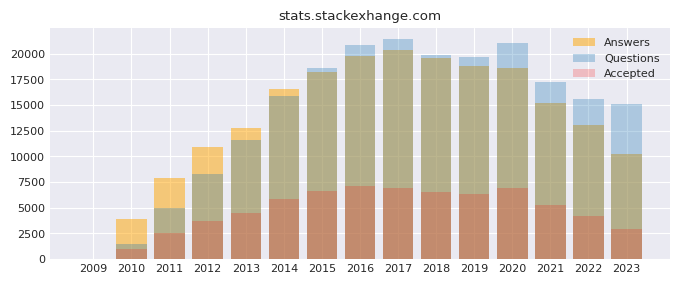

In [11]:
fig,ax=plt.subplots(figsize=(8,3))
ax.bar(np.arange(cnt_arr_a.shape[0]), cnt_arr_a[:,1], alpha=0.5, color='orange')
ax.bar(np.arange(cnt_arr_q.shape[0]), cnt_arr_q[:,1], alpha=0.3)
ax.bar(np.arange(cnt_arr_accpt.shape[0]), cnt_arr_accpt[:,1], alpha=0.2, color='r')

ax.set_xticks(np.arange(cnt_arr_q.shape[0]))
ax.set_xticklabels(cnt_arr_q[:,0])
ax.legend(['Answers', 'Questions', 'Accepted'])
ax.set_title('stats.stackexhange.com');

In [12]:
( len(questions),
 sum([len(v)>1 for k,v in qa_dict.items()]),
 np.mean([len(v)>1 for k,v in qa_dict.items()]),
 questions[-1]['CreationDate']
)

(211634, 142915, 0.675293194855269, '2023-12-03T02:17:25.083')

That's the big picture. The data spans years 2009-2023, ending at Dec 2023 (that's arbitrary endpoint, more recent data might be added later). There are 211,634 questions in total, 142,915 (68%) of them answered. Total activity appears to be on the decline.

The goal I stated above could be naturally cast as a binary classification problem. However, answers arrive at different times, some of them perhaps too late to be useful to the original question poster.

In [23]:
answ_day = defaultdict(int)
for qid, answ in tqdm(qa_dict.items()):
    if len(answ)>1:
        ix_day = np.floor((answers_dict[answ[0]]['uxtime'] - questions_dict[qid]['uxtime'])/(24*60*60))
        answ_day[ix_day]+=1

100%|██████████| 211634/211634 [00:00<00:00, 223118.34it/s]


In [27]:
answ_arr = np.array(sorted(list(answ_day.items()),
                           key=lambda x:x[0]), dtype=np.int32)

In [28]:
# apparently few questions were answered even before the question was asked. That's fast!
answ_arr[0:15]

array([[  -955,      1],
       [  -624,      1],
       [  -442,      1],
       [  -284,      1],
       [  -274,      1],
       [    -3,      1],
       [    -2,      3],
       [    -1,     16],
       [     0, 105918],
       [     1,   7086],
       [     2,   3539],
       [     3,   2188],
       [     4,   1535],
       [     5,   1307],
       [     6,    996]], dtype=int32)

In [58]:
answ_arr = answ_arr[8:]

### Response Timing
[[To the top]](#contents)


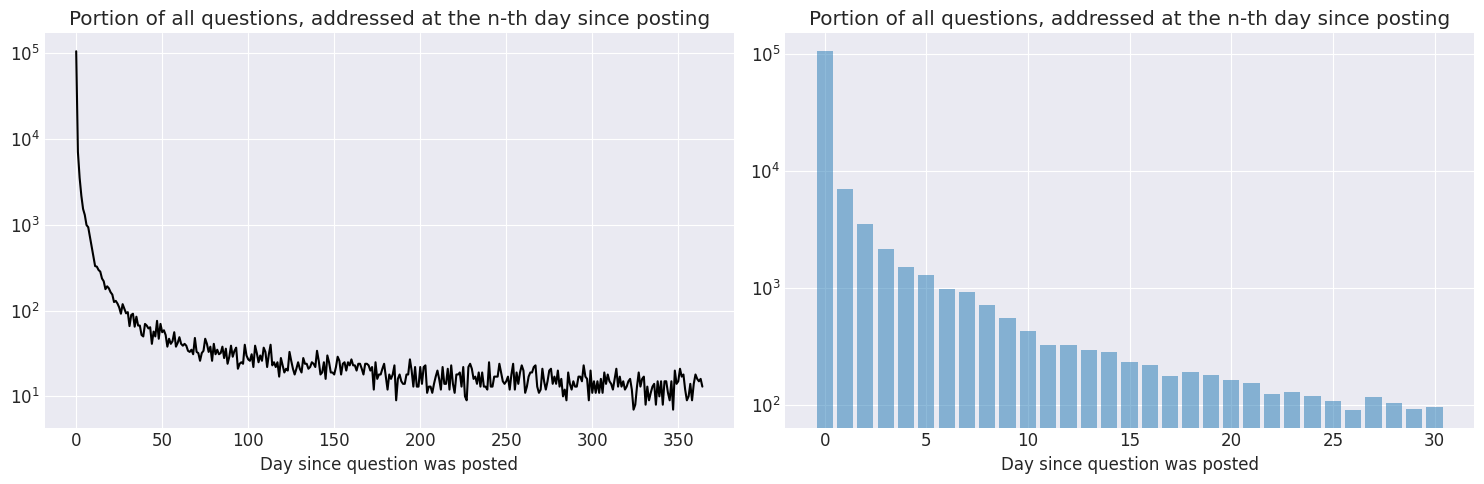

In [70]:
plt.rcParams.update({'font.size': 12})

fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].set_yscale('log')
ax[0].plot(answ_arr[:365,0], answ_arr[:365,1], c='k')

ax[0].set_xlabel('Day since question was posted')
ax[0].set_title('Portion of all questions, addressed at the n-th day since posting')

ax[1].set_yscale('log')
ax[1].bar(answ_arr[:31,0], answ_arr[:31,1], alpha=0.5)

ax[1].set_xlabel('Day since question was posted')
ax[1].set_title('Portion of all questions, addressed at the n-th day since posting');
plt.tight_layout(w_pad=1)

In [85]:
answ_arr[-10:], answ_arr[-1,0]/365

(array([[4102,    1],
        [4136,    1],
        [4181,    1],
        [4197,    1],
        [4243,    1],
        [4357,    1],
        [4480,    1],
        [4508,    1],
        [4514,    1],
        [4760,    1]], dtype=int32),
 13.04109589041096)

The figures show that most questions are addressed on the same day they were posted. There are more than ten times less responses on the second day, and their number gradually decreases with time. On the plots above I zoomed in on the first year and first month (left and right fig respectively), but the tail goes long, with the latest response coming 13 years later!

It doesn't seem like a data issue, there are more than a thousand questions addressed more than five years later (see below), and I checked some of them out on the website.

In [83]:
late_comers = []
for qid, answ in qa_dict.items():
    if len(answ)>1:
        if np.floor((answers_dict[answ[0]]['uxtime'] - questions_dict[qid]['uxtime'])/(24*60*60))/365>5:
            late_comers.append(qid)

In [84]:
# questions that were addressed more than 5 years later 
len(late_comers)

1018

If we instead look at *cumulative* portion of questions, addressed on the n-th day, we see that the tail is quite heavy.

In [87]:
plt.rcParams.update({'font.size': 8})

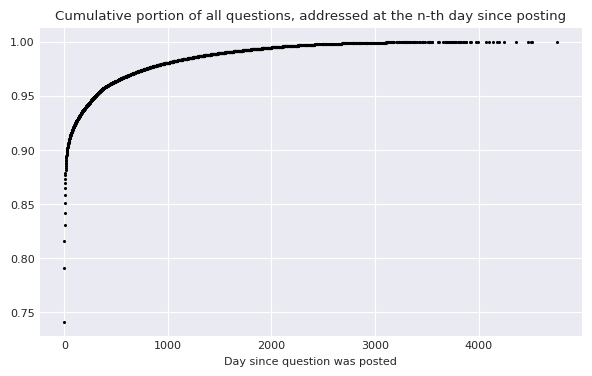

In [88]:
fig,ax=plt.subplots(figsize=(7,4))
ax.scatter(answ_arr[:,0], np.cumsum(answ_arr[:,1]) / np.sum(answ_arr[:,1]), s=1.5, c='k')

ax.set_xlabel('Day since question was posted')
ax.set_title('Cumulative portion of all questions, addressed at the n-th day since posting');

In [91]:
[ f'{i:<3} {percent:.3f}' for i,percent in enumerate((
    np.cumsum(answ_arr[:,1]) / np.sum(answ_arr[:,1]))[:31])]

['0   0.741',
 '1   0.791',
 '2   0.816',
 '3   0.831',
 '4   0.842',
 '5   0.851',
 '6   0.858',
 '7   0.864',
 '8   0.869',
 '9   0.873',
 '10  0.876',
 '11  0.879',
 '12  0.881',
 '13  0.883',
 '14  0.885',
 '15  0.887',
 '16  0.888',
 '17  0.889',
 '18  0.891',
 '19  0.892',
 '20  0.893',
 '21  0.894',
 '22  0.895',
 '23  0.896',
 '24  0.897',
 '25  0.898',
 '26  0.898',
 '27  0.899',
 '28  0.900',
 '29  0.901',
 '30  0.901']

The first day gets only 74% of all responses. First month only 90%. After that there is a long smooth tail, without obvious (sudden) outliears.

In terms of usefulness for an ordinary website visitor (not hardcore academics), perhaps responses with time lags larger than one month are useless, so I would treat as positive class only questions, addressed in one month.

### Feature Design 
[[To the top]](#contents)


### 1 Overview 

To get a sense of what features might be relevant it's instructive to spend some time on the website. Here's the outline of the question-answer dynamics.

The question-supply side: 

- A user visits the website and inputs his question. Website features a useful recommendation system. Each page is devoted to a single question. On the right you can see 'Related' and 'Linked' questions.

- After going through a number of related questions, user decides to submit his own question (there is a handy foolproof feature: as you type in the title of your question, the system brings up a list of close questions on the website; curiously, sometimes it feels like this way of searching works better, and it's not just me: https://meta.stackexchange.com/questions/20432/related-questions-in-ask-question-page-is-better-than-the-search-tool?noredirect=1&lq=1).

The answer-supply side:

- New question just posted could be seen on the home page https://stats.stackexchange.com/ if you sort by recency. After some time it will be superseded by more recent questions and will be pushed progressively into pages 2, 3, 4 and so on of the newest questions, losing its visibility.

- Aside from the 'newest' page, this questions could be reached via 'unanswered' questions (while it still has no answers), via tags filtering, via related/linked questions (I don't how much time it takes for recommendation system to accomodate new questions), via sorting by upvotes, and some other means

Based on that, it makes sense to use features of two kinds:

### 2 Individual-Question Features

1. Features derived from the question's title/body: a couple of indicators like "is there source code in the question body?", "are there math formulas?", etc; body/title length. 

   As for question body, I've tried a bag of words, but using embedding vector from sentence-transformers resulted in a better gain (each dimension of a vector as a separate numeric column)    

2. Owner's reputation  
One of my hypotheses from the outset was that users with low reputation (ie newcomers) are often ignored, no matter what their question is. Reputation seems to be a good proxy for the value of user's past contributions and overall "good sense". There is also a distinct group of whales, with long history of various contributions and hundreds of questions asnwered. I'd guess their presence (as a question poster or as a replier) would attract those, who wouldn't have attended otherwise.

3. Standard datetime features

### 3 Contextual Features

That's the most interesting part. We can treat question's history as a time series -- the way it's presented on the home page. For each question I consider previous questions, posted within an 1 hour, 2 hours, ..., 1 day, 1 week, 1 month before it. For them I compute several aggregates, usually 0.05, 0.5 and 0.95 quantiles. Aggregates are computed over the following quantities: 

1. Number of responses
2. Question's score (number of upvotes)
3. Owner's reputation (in this case I take the difference between current question owner's reputation and reputations of recent preceeding questions)

Temporal closeness defines one of the contexts. Another is defined by relatedness, as suggested by website's recommendation system (section 'Related' on the question's page). Again, I take the group of related questions and compute the same aggregates over them.   

### 4 Tricky Part

With time series it's crucial not to leak information from the future. In my case it leads to the following caveats:

- I can't just scrape the question from the website and parse its feilds into features, because that's not what potential repliers saw **when it was posted**. Since then it has been upvoted/downvoted and edited, its owner has gained or lost reputation and so on. This means we need the whole post/user history.

- Another detail is that the resulting data structure is not an ordinary time series. Consider this example: there are 100 questions q_0 .. q_99. We compute aggregates for the question q_90 (over, say, 20 preceding questions q_70..q_89). Then we move on to question q_91. Now we shift the window one step (q_71..q_90), but we can't compute aggregats right away, because all those questions **changed during the time before q_91 arrived**. All of them have to be updated and only then aggregates are computed. 

  Those updates slow things down significantly if aggregates are computed from sratch for every feature. I've written a procedure that performs updates in a more incremental way, to get rid of redundant re-calculations.     

### Next goes a tedious chain of data loading
[[To the top]](#contents)

### Post History

In [13]:
root = ( ET.parse(f'{dump_path}/PostHistory.xml')
        .getroot())
phist = [x.attrib for x in root]

for x in tqdm(phist):
    to_int(x, ['Id', 'PostHistoryTypeId', 'UserId', 'PostId'])
    parse_time(x)
    
    
phist_dict = defaultdict(list)
for x in tqdm(phist):
    phist_dict[x['PostId']].append(x)
    
for k in phist_dict.keys():
    phist_dict[k] = sorted(phist_dict[k], key=lambda x: x['uxtime']) #+ [guard_node]

100%|██████████| 1504094/1504094 [00:50<00:00, 29842.13it/s]

100%|██████████| 1504094/1504094 [00:01<00:00, 808116.88it/s]


### Post Votes

In [15]:
root = ( ET.parse(f'{dump_path}/Votes.xml')
        .getroot())
votes = [x.attrib for x in root]
score_change = { 
    2: 1,  # upvote
    3: -1, # downvote
}

for x in tqdm(votes):
    to_int(x, ['Id', 'PostId', 'VoteTypeId', 'BountyAmount'])
    parse_time(x)
    x['score_change'] = score_change.get(x['VoteTypeId'], 0) 

100%|██████████| 1702057/1702057 [00:55<00:00, 30508.40it/s]


In [16]:
post_votes = defaultdict(list)

for x in tqdm(votes):
    post_votes[x['PostId']].append(x)
    
for pid in tqdm(posts_dict.keys()):
    if pid in post_votes:
        post_votes[pid] = sorted(post_votes[pid], key=lambda x: x['uxtime']) + [guard_node]
    else:
        post_votes[pid] = [guard_node]

100%|██████████| 1702057/1702057 [00:02<00:00, 689961.75it/s]

100%|██████████| 420389/420389 [00:02<00:00, 175607.64it/s]


### Users

In [17]:
root = ( ET.parse(f'{dump_path}/Users.xml')
        .getroot())
users = [x.attrib for x in root]
for u in users:
    to_int(u, ['Id', 'Reputation'])
    parse_time(u)

users_dict = {x['Id']:x for x in users}

### Reputation History

In [43]:
with open('reputation_hist_full.json', 'r') as f:
    hist = json.load(f)

user_rep = {}
for uid, u in users_dict.items():
    user_rep[uid] = u['Reputation']

#hist = []
#for path in glob(f'{rep_history_path}/*'):
#    with open(path, 'r') as f:
#        hist += json.load(f)['items']
        
def first_rep_increment(uid):
    return { 'reputation_history_type': 'registration',
            'reputation_change': 1,
            'creation_date': users_dict[uid]['uxtime']}

user_hist = defaultdict(list)
for h in tqdm(hist):
    user_hist[h['user_id']].append(h)

for uid in user_hist.keys():
    user_hist[uid] = [first_rep_increment(uid)] + \
    sorted(user_hist[uid], key=lambda x: x['creation_date']) + [guard_node]
    
    # in some weird cases user's creation_date is later than dates of his reputation changes
    # This happens due to post migrations and profile merges
    # see https://meta.stackexchange.com/questions/376301/how-can-a-users-creationdate-be-after-they-have-posted
    # Fix datetime order if needed
    if (user_hist[uid][0]['creation_date']>user_hist[uid][1]['creation_date']) and \
    len(user_hist[uid])>2:
        user_hist[uid][0]['creation_date'] = user_hist[uid][1]['creation_date']
    
# Users with empty reputation history (as per API) have reputation 1, assigned after registration
# This single score is not visible in the rep history, fetched via API, so I add it manually 
for uid in [ uid for uid in set(user_rep.keys()) - set(user_hist.keys()) if user_rep[uid]==1]:
    user_hist[uid] = [first_rep_increment(uid), guard_node]

100%|██████████| 1915714/1915714 [00:01<00:00, 1121949.01it/s]


In [44]:
# Beware, some users, like id: 146980, have non-zero reputation (355), but 
# empty reputation history (as per API), and their page users/146980 is absent from the website
straw_users = [ uid for uid in users_dict.keys() if uid not in user_hist]
straw_users

[27028, 146980, 272831, 297820, 357234, 391929, 401629, 401774]

In [20]:
# uproot them altogether, because their rep hist is not available
cnt_occurences = 0
for x in questions:
    if x.get('OwnerUserId',-1) in straw_users:
        cnt_occurences+=1
        del x['OwnerUserId']
        
for x in answers:
    if x.get('OwnerUserId',-1) in straw_users:
        cnt_occurences+=1
        del x['OwnerUserId']

### Few More Notes On Features

- I remove the last month worth of questions, because they might have been answered right after my data ends. They can'be reliably labeled yet.

- I remove questions before year 2015. The cutoff is arbitrary, but the point is that when the website was just taking off, the dynamics probably was very different from today's: very few users, very few questions, etc.

- When I compute aggregates over 'related' questions (suggested by recommendation system (RS)) I pick only those, created before the target question, to avoid data leak. But I am not sure that RS suggested them in the same manner back then. They might have been linked later, or RS algorithm has changed since. 

  I've decided to use them anyway. If they weren't suggested by RS back then, at least they were certainly available on the website and users could find them anyway, through manual search or google. So I use 'related' questions simply as "similar enough", **as judged by RS of today**.

In [21]:
# take questions since 2014 (arbitrary year). 
# Early years might be less informative
start_ix = 0
while questions[start_ix]['parsed_time'].tm_year<2014:
    start_ix += 1

# Remove recent questions w/t ansxwers, as they might have been answered
# shortly after data dump ends
end_ix = len(questions)-2
while questions[-1]['uxtime'] - questions[end_ix]['uxtime'] < 30*24*60*60:
    end_ix -= 1

In [ ]:
timing = np.zeros(end_ix-start_ix)-1
for i in range(start_ix, end_ix):
    qid = questions[i]['Id']
    timing[i-start_ix] = np.floor((answers_dict[qa_dict[qid][0]]['uxtime'] -\
                                   questions_dict[qid]['uxtime'])/(24*60*60))
# save for later    
np.save('timing.npy', timing)

### View Count

Question's view count is shown on question preview and seems like an obvious measure of popularity. Unfortunately, dump only includes final view counts, not their history, hence it can't be used as a feature. Still, final view counts could be inspected to gain some insight into relation between question popularity and probability of being addressed.

In [22]:
view_cnt = np.array([q['ViewCount'] for q in questions])
answ_cnt = np.array([q['AnswerCount'] for q in questions])
score_cnt = np.array([q['Score'] for q in questions])

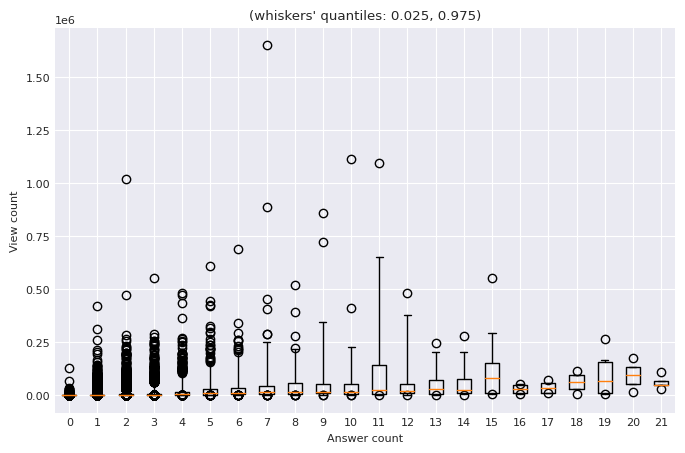

In [10]:
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot([view_cnt[answ_cnt==i] for i in range(22)], 
           whis=[2.5,97.5],
          positions=range(22))
ax.set_ylabel('View count')
ax.set_xlabel('Answer count');
ax.set_title('(whiskers\' quantiles: 0.025, 0.975)');

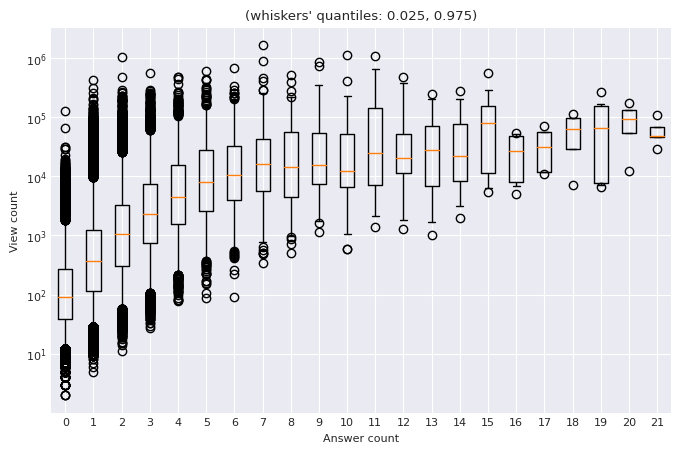

In [26]:
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot([view_cnt[answ_cnt==i] for i in range(22)], 
           whis=[2.5,97.5],
           positions=range(22))
ax.set_ylabel('View count')
ax.set_xlabel('Answer count')
ax.set_title('(whiskers\' quantiles: 0.025, 0.975)')
ax.set_yscale('log')

Log-scale plot shows clear monotonic relation (with saturation) between view count and answer count. This and the fact that most questions are addressed in the first day suggest that

1. question visibility is probably important

In [26]:
edit_cnt = np.array([sum(x['PostHistoryTypeId'] in [4,5,6,7,8,9,24] for x in phist_dict[q['Id']]) 
                     for q in questions])

In [28]:
edit_cnt_unique = np.unique(edit_cnt)
edit_cnt_unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 39, 42, 69])

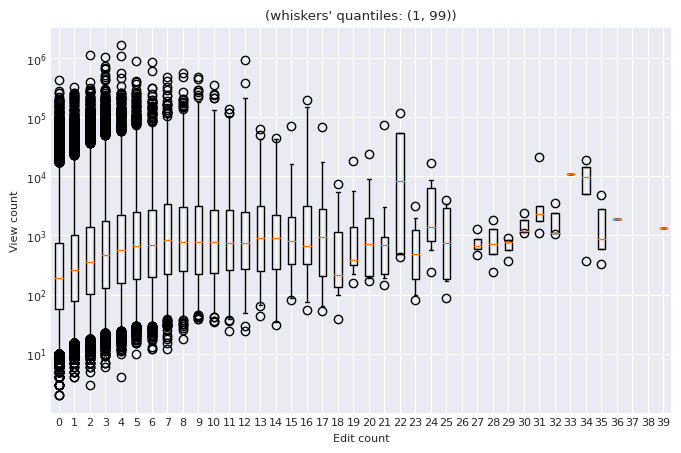

In [39]:
whisk = (1,99)
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot([view_cnt[edit_cnt==i] for i in np.arange(40)], 
           whis=whisk,
           positions=np.arange(40))
ax.set_ylabel('View count')
ax.set_xlabel('Edit count')
ax.set_title(f'(whiskers\' quantiles: {whisk})')
#ax.set_ylim((-1, 40))
ax.set_yscale('log')

### Feature Calculation

### Sliding Window Features
[[To the top]](#contents)

In [19]:
quantile = lambda arr: np.nanquantile(arr, [0.05, 0.5, 0.95])

# guard is supposed to be unreachable
WIND_GUARD = 300*24*7*60*60
windows = [60*60, 6*60*60, 24*60*60, 72*60*60, 24*7*60*60, 4*24*7*60*60, WIND_GUARD ]
suffx = ['1hour', '6hours', '24hours', '72hours', 'week', 'month']

def process_single_question(i_question, i, cur, uxt,
                            score_cnt,
                            ans_cnt,
                            rep_cnt,
                            score_ix,
                            ans_ix,
                            rep_ix):
    '''
    Parameters
    ----------
    i_question : int
        Absolute (within `questions` list) index of the question to process
    i : int
        Index within arrays `ans_cnt`, 'ans_ix', etc, corresponding to this question
    cur : dict
        Current feature dict to save features to
    uxt : float
        Unix time of the target question (question we build features for)
    '''
    cur_q = questions[i_question]
    cur_id = cur_q['Id']
            
    while answers_dict[qa_dict[cur_id][ ans_ix[i] ]]['uxtime']<uxt: 
        ans_ix[i]+=1
    
    ans_cnt[i] = ans_ix[i]

    while post_votes[cur_id][ score_ix[i] ]['uxtime']<uxt:
        score_cnt[i]+=post_votes[cur_id][ score_ix[i] ]['score_change']
        score_ix[i]+=1
    
    if 'OwnerUserId' in cur_q:
        while user_hist[cur_q['OwnerUserId']][ rep_ix[i] ]['creation_date']<uxt:
            rep_cnt[i] += user_hist[cur_q['OwnerUserId']][rep_ix[i]]['reputation_change']
            rep_ix[i]+=1
    else:
        rep_cnt[i] = np.nan

    
def compute_aggregates(ans_cnt, score_cnt, rep_cnt, cur, suffx):
    n = ans_cnt.shape[0]
    qs = quantile(ans_cnt if n>0 else [0])
    cur[f'total_answ_cnt_last_{suffx}'] = np.sum(ans_cnt)
    
    cur[f'q95_answ_cnt_last_{suffx}'] = qs[2]
    cur[f'q50_answ_cnt_last_{suffx}'] = qs[1]
    cur[f'q05_answ_cnt_last_{suffx}'] = qs[0]
            
    cur[f'total_questions_last_{suffx}'] = n 
    #cur[f'avg_accpt_answers_last_{suffx[k]}'] = accpt_cnt/(lag-1)
    
    arr = score_cnt if n>0 else [np.nan]
    qs = quantile(arr)
    
    cur[f'total_score_last_{suffx}'] = np.sum(arr)
    cur[f'std_score_last_{suffx}'] = np.std(arr)
    cur[f'q95_score_last_{suffx}'] = qs[2]
    cur[f'q50_score_last_{suffx}'] = qs[1]
    cur[f'q05_score_last_{suffx}'] = qs[0]
    cur[f'dist_max_score_{suffx}'] = np.argmax(arr)
    cur[f'dist_min_score_{suffx}'] = np.argmin(arr)
    
    if (cur['owner_reputation'] is not None) and (np.any(~np.isnan(rep_cnt))):
        
        diff_rep = cur['owner_reputation'] - rep_cnt
        qs = quantile(diff_rep)

        cur[f'std_diff_reputation_last_{suffx}'] = np.nanstd(diff_rep)
        cur[f'q95_diff_reputation_last_{suffx}'] = qs[2]
        cur[f'q50_diff_reputation_last_{suffx}'] = qs[1]
        cur[f'q05_diff_reputation_last_{suffx}'] = qs[0]
        cur[f'dist_max_diff_reputation_{suffx}'] = np.nanargmax(diff_rep)
        cur[f'dist_min_diff_reputation_{suffx}'] = np.nanargmin(diff_rep)
        

def reset_buffers(buff_size, n_recent, 
                  score_cnt,
                  ans_cnt,
                  rep_cnt,
                  score_ix,
                  ans_ix,
                  rep_ix):
    
    score_cnt[buff_size:buff_size+n_recent] = score_cnt[:n_recent]
    ans_cnt[buff_size:buff_size+n_recent] = ans_cnt[:n_recent]
    rep_cnt[buff_size:buff_size+n_recent] = rep_cnt[:n_recent]
    
    score_cnt[:buff_size] = 0
    ans_cnt[:buff_size] = 0
    rep_cnt[:buff_size] = 0
    
    score_ix[buff_size:buff_size+n_recent] = score_ix[:n_recent]
    ans_ix[buff_size:buff_size+n_recent] = ans_ix[:n_recent]
    rep_ix[buff_size:buff_size+n_recent] = rep_ix[:n_recent]
    
    score_ix[:buff_size] = 0
    ans_ix[:buff_size] = 0
    rep_ix[:buff_size] = 0

There is also a slower, more straightforward procedure for checking correctness of the faster procedure

In [20]:
def featurize_old(start_ix, end_ix):
    #lags1 = []
    #arrs1 = []
    feats = []
    for i in tqdm(range(start_ix, end_ix)):
        lag = 1
        uxt = questions[i]['uxtime']
        cur = {}
        cur['owner_reputation'] = \
        sum([ rep['reputation_change'] for rep in user_hist[questions[i]['OwnerUserId']] 
             if rep['creation_date']<uxt]) if 'OwnerUserId' in questions[i] else None 

        #lags1.append([])
        for i_window in range(len(windows)-1):
            while uxt - questions[i-lag]['uxtime'] <= windows[i_window]:
                lag+=1

            ans_cnt = [sum([answers_dict[aid]['uxtime']<uxt for aid in qa_dict[q['Id']]]) for q in questions[i-lag+1: i]]
            score_cnt = [sum([vote['score_change'] for vote in post_votes[q['Id']] if vote['uxtime']<uxt]) for q in questions[i-lag+1: i]]
            #if 'OwnerUserId' in questions[i]:
            rep_cnt = [sum([event['reputation_change'] for event in user_hist[q['OwnerUserId']]
                                if event['creation_date']<uxt]) if 'OwnerUserId' in q else np.nan for q in questions[i-lag+1: i] ]

            #lags1[-1].append(lag)
            #arrs1.append([ np.array(ans_cnt)[::-1],
            #                   np.array(score_cnt)[::-1],
            #                   np.array(rep_cnt)[::-1],])
            compute_aggregates(np.array(ans_cnt)[::-1],
                               np.array(score_cnt)[::-1],
                               np.array(rep_cnt, dtype=np.float32)[::-1], cur, suffx[i_window])
        feats.append(cur)
    return feats

In [21]:
def featurize(start_ix, end_ix, 
              max_window_sz=2100, 
              buff_size=20000):
    
    score_cnt = np.zeros(buff_size + max_window_sz, dtype=np.int32)
    ans_cnt = np.zeros(buff_size + max_window_sz, dtype=np.int32 )
    # float32 to enable NaNs
    rep_cnt = np.zeros(buff_size + max_window_sz, dtype=np.float32)

    score_ix = np.zeros(buff_size + max_window_sz, dtype=np.int32)
    ans_ix = np.zeros(buff_size + max_window_sz, dtype=np.int32)
    rep_ix = np.zeros(buff_size + max_window_sz, dtype=np.int32)

    feats = []

    lag = max_window_sz-1
    i_q = start_ix
    buff_offset = 0
    with tqdm(total=end_ix-start_ix) as pbar:
        while i_q < end_ix:

            # skip the oldest questions, that were recent for the previous question, 
            # but not recent for the current one
            while questions[i_q]['uxtime'] - questions[i_q-lag]['uxtime'] > windows[-2]:
                lag -= 1

            #lags.append([])

            n_recent = lag
            i_window = 0
            cur = {}
            uxt = questions[i_q]['uxtime']
            cur['owner_reputation'] = \
                sum([ rep['reputation_change'] for rep in user_hist[questions[i_q]['OwnerUserId']] 
                     if rep['creation_date']<uxt]) if 'OwnerUserId' in questions[i_q] else None 

            # n_recent+1 because we include n_recent'th question
            # n_recent+2 because we have to step *beyond* the last (widest) window 
            # to trigger condition `uxt - questions[i_q-lag]['uxtime'] > windows[i_window]` 

            lag = 1
            while lag<n_recent+2:
                #if i_q==start_ix+5 and lag==528:
                #    pdb.set_trace()

                process_single_question(i_q - lag, buff_size - buff_offset + lag-1, cur, uxt, 
                                        score_cnt, ans_cnt, rep_cnt, score_ix, ans_ix, rep_ix)    

                # the reason for this loop is this:
                # suppose the next question is 10 hours ahead of the current one.
                # This means that all the windows shorter than 10 hours 
                # won't get any new questions, so we compute their aggregates all at once
                # 
                while uxt - questions[i_q-lag]['uxtime'] > windows[i_window]:    
                    #lags[-1].append(lag)
                    _slice = slice(buff_size - buff_offset, buff_size - buff_offset + lag - 1)

                    #arrs.append([ans_cnt[_slice].copy(), 
                    #           score_cnt[_slice].copy(),
                    #           rep_cnt[_slice].copy()])
                    compute_aggregates(ans_cnt[_slice], 
                                       score_cnt[_slice],
                                       rep_cnt[_slice],
                                       cur, suffx[i_window])
                    i_window+=1
                lag+=1

            #lags[-1].append(lag)   
            i_q += 1
            buff_offset += 1
            feats.append(cur)
            pbar.update(1)

            if buff_offset>buff_size:
                reset_buffers(buff_size, n_recent+2, score_cnt,
                             ans_cnt, rep_cnt, score_ix, ans_ix, rep_ix)
                buff_offset=1
    return feats

In [22]:
def max_questions_within_period(start_ix, period):
    max_cnt=1
    start_date_ix = start_ix
    i=start_ix+1
    while i<len(questions):
        while i<len(questions) and (questions[i]['uxtime']-questions[start_date_ix]['uxtime']<period):
            i+=1
        if i-start_date_ix>max_cnt:
            max_cnt=i-start_date_ix
        start_date_ix+=1
    return max_cnt

In [23]:
# maximal number of questions, that fit into widest window 
max_questions_within_period(start_ix, windows[-2])

2087

Incremental code is more than 10 times faster, than naive baseline

In [48]:
end_ix = start_ix + 5000

In [24]:
feats = featurize(start_ix, end_ix)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered

  return _nanquantile_unchecked(

100%|██████████| 5000/5000 [01:04<00:00, 77.41it/s]


In [25]:
df1 = pd.DataFrame(feats)

In [26]:
feats = featurize_old(start_ix, end_ix)
df2 = pd.DataFrame(feats)

100%|██████████| 5000/5000 [13:46<00:00,  6.05it/s]


In [27]:
df2 = pd.DataFrame(feats)

In [29]:
np.allclose(df1.values, df2.values, rtol=0, atol=1e-6, equal_nan=True)

True

### Non-sliding-window Features
[[To the top]](#contents)

There is a separate loop for features that can't be processed in incremental way.  
First we load related questions (as defined by recommendation system)

In [31]:
with open('/kaggle/input/related-full/related_full.json', 'r') as f:
    related = json.load(f)
related = {int(k):v for k,v in related.items()}

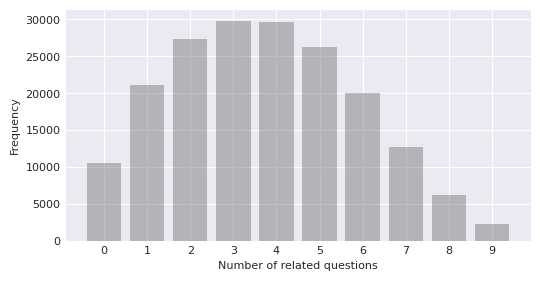

In [36]:
cnts, bins = np.histogram(np.array([len(v) for k,v in related.items()]))

fig,ax=plt.subplots(figsize=(6,3))
ax.bar(np.arange(cnts.shape[0]), cnts, alpha=0.5, color='grey')

ax.set_xticks(np.arange(cnts.shape[0]))
ax.set_xticklabels(bins[:-1].astype(np.int16))
ax.set_xlabel('Number of related questions')
ax.set_ylabel('Frequency');

In [37]:
import re
sub = [
    # links
    #r'(<a href(.*?)</a>)',
    # code sections
    r'(<pre><code>((.|\n)*?)</code></pre>)',
    # tags
    r'(<(.*?)>)',
]    

In [38]:
quantile = lambda arr: np.nanquantile(arr, [0.05, 0.5, 1.])

feats = []

for i in tqdm(range(start_ix, end_ix)):
    q = questions[i]
    cur = {}
    
    cur['question_id'] = q['Id']
    dt = q['parsed_time']
    cur['asked_dayofweek'] = dt.tm_wday
    cur['asked_day']       = dt.tm_mday
    cur['asked_hour']      = dt.tm_hour
    cur['asked_month']     = dt.tm_mon
    cur['is_2020']         = int(dt.tm_year==2020) # covid
    uxt = q['uxtime']
    
    cur['is_answered'] = q['AnswerCount']>0

    # ---------------------------- Related Questions ----------------------------------
    
    rel = [qid for qid in related.get(q['Id'],[]) if questions_dict[qid]['uxtime']<uxt]
    cur['rel_total_num'] = len(rel) if len(rel)>0 else np.nan
    
    if len(rel)>0:
        qs = quantile([sum([x['score_change'] for x in post_votes[qid] if x['uxtime']<uxt]) for qid in rel])
        cur['related_max_score'] = qs[2]
        cur['related_q50_score'] = qs[1]

        linked_ans_num = [sum([ answers_dict[aid]['uxtime']<uxt for aid in qa_dict[qid]]) for qid in rel]
        cur['related_total_ans_given'] = np.sum(linked_ans_num)
        # np.median will be nan for empty lists (no related)
        cur['related_q50_ans_given']   = np.median(linked_ans_num)                                       

        #qs = quantile([x['ViewCount'] for x in rel])
        #cur['linked_q95_viewcnt'] = qs[2]
        #cur['linked_q50_viewcnt'] = qs[1]

        rel_rep = [ sum([ rep['reputation_change'] for rep in user_hist[questions_dict[qid]['OwnerUserId']] 
             if rep['creation_date']<uxt]) for qid in rel if 'OwnerUserId' in questions_dict[qid]]
        if len(rel_rep)>0:
            qs = quantile(rel_rep)
            cur['linked_max_rep'] = qs[2]
            cur['linked_q50_rep'] = qs[1]

        # ---------------------------- Related Answers ----------------------------------

        rel_ans = [aid for qid in rel \
                   for aid in qa_dict[qid] if answers_dict[aid]['uxtime']<uxt]
        if len(rel_ans)>0:
            qs = quantile([sum([x['score_change'] for x in post_votes[aid] if x['uxtime']<uxt]) for aid in rel_ans])
            cur['total_linked_ans'] = len(rel_ans)
            cur['linked_ans_max_score'] = qs[2]
            cur['linked_ans_q50_score'] = qs[1]
            cur['linked_ans_q05_score'] = qs[0]

            rel_ans_rep = [ sum([ rep['reputation_change'] for rep in user_hist[answers_dict[aid]['OwnerUserId']] 
                 if rep['creation_date']<uxt]) for aid in rel_ans if 'OwnerUserId' in answers_dict[aid]]
            if len(rel_ans_rep)>0:
                cur['linked_ans_max_reputation'] = qs[2]
                cur['linked_ans_q50_reputation'] = qs[1]
                cur['linked_ans_q05_reputation'] = qs[0]

    # ---------------------------- (Basic) Text Features ----------------------------------
    flag=0
    k=0
    while flag<2:
        x = phist_dict[q['Id']][k]
        if x['PostHistoryTypeId']==1:
            title = x['Text']
            flag+=1
        elif x['PostHistoryTypeId']==2:
            body = x['Text']
            flag+=1
        k+=1
    
    cur['title_len'] = len(title)
    cur['body_len'] = len(body)
    
    body_clean = body
    for pttn in sub:
        body_clean = re.sub(pttn, '', body_clean)
    cur['body_clean1_len'] = len(body_clean)
    cur['code_etc_len'] = cur['body_len'] - cur['body_clean1_len']
    
    cur['contains_latex'] = ('$$' in body) or ('math-container' in body)
    cur['contains_code'] = '<pre><code>' in body
    cur['num_question_marks'] = sum([x=='?' for x in body])
    cur['contains_img'] = '<img src' in body
    cur['contains_link'] = 'https://' in body
    
    feats.append(cur)

100%|██████████| 5000/5000 [00:17<00:00, 287.31it/s]


In [90]:
df = pd.DataFrame(feats)
df = pd.concat([df1, df], axis=1)

### Tags
[[To the top]](#contents)

Tags are attached to the question by question owner. I treat them as binary indicators. There are 1613 in total: 1610 retrieved via API and 3 extra tags from data dump 

In [40]:
with open('/kaggle/input/tags-synonyms/tags.json', 'r') as f:
    tags = json.load(f)['items']

In [41]:
len(tags)

1610

In [43]:
groups = []
tag2group = {}
for t in tags:
    if t['name'] not in tag2group: 
        tag2group[t['name']] = len(groups)
        group = [t['name']]
        
        for s in t.get('synonyms', []):
            tag2group[s] = len(groups)
            group.append(s)
        groups.append(group)
        
# additional tags from data dump, 
# absent from the list, retrieved via API
tag2group['group-lasso'] = len(groups)
tag2group['best-subset'] = len(groups)
groups.append(['group-lasso', 'best-subset'])

# (sic)
tag2group['levels-of-measurment'] = len(groups)
groups.append(['levels-of-measurment'])

In [52]:
feats_tag = np.zeros((end_ix-start_ix, len(groups)))

In [53]:
for i,q in enumerate(questions[start_ix: end_ix]):
    feats_tag[i][[tag2group[tag] for tag in q['Tags'][1:-1].split('><')]] = 1

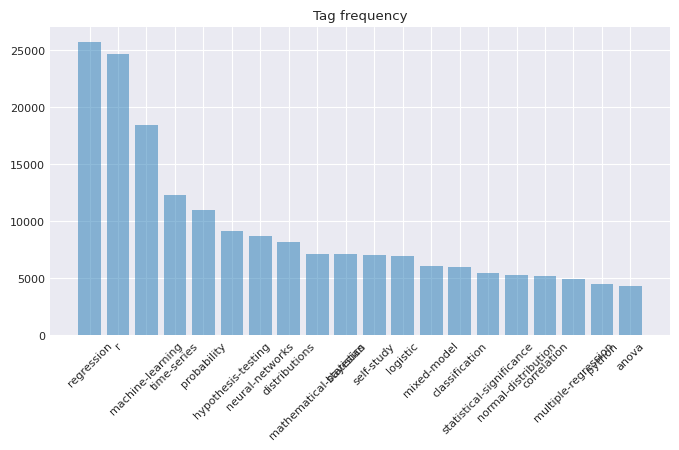

In [77]:
tag_freq = feats_tag.sum(axis=0)
top_k = np.argsort(tag_freq)[-20:][::-1]
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(np.arange(top_k.shape[0]), tag_freq[top_k], alpha=0.5)

ax.set_xticks(np.arange(top_k.shape[0]))
ax.set_xticklabels([groups[i][0] for i in top_k], rotation=45)
ax.set_title('Tag frequency');

But most of them are rare (lightgbm would filter them out even before training). For example there are 739 tags, attached to less than 50 questions, 1342 tags, attached to less than 500 questions, and the most popular tag 'regression' figures only in 25720 questions (14% of the total)

In [118]:
( np.sum(np.sort(tag_freq)<50), 
 np.sum(np.sort(tag_freq)<500),
 end_ix-start_ix,
 tag_freq.max()/(end_ix-start_ix),
)

(739, 1342, 184123, 0.13968922948246554)

In [88]:
df = pd.concat([df, pd.DataFrame(feats_tag, 
                                 columns = [f'tag_{groups[i][0]}' for i in range(len(groups))],
                                 )], axis=1)

In [93]:
cat_cols = ['asked_day', 'asked_hour', 'asked_month' ] +\
[col for col in df.columns if ('tag_' in col)] + ['contains_latex', 'contains_code',
                                                  'contains_img', 'contains_link',
                                                 'is_2020'] 

In [92]:
df = df.astype({col: np.int16 for col in ['is_answered'] + cat_cols})

In [94]:
! ls -la /kaggle/input/intermed-results-1

total 1140240

drwxr-xr-x 2 nobody nogroup         0 Mar  4 09:24 .

drwxr-xr-x 8 root   root         4096 Mar  4 09:25 ..

-rw-r--r-- 1 nobody nogroup  36341722 Mar  4 09:25 df_no_emb_Feb21.parquet

-rw-r--r-- 1 nobody nogroup 565625984 Mar  4 09:25 emb_Feb27_not_cleaned.npy

-rw-r--r-- 1 nobody nogroup 565625984 Mar  4 09:25 emb_Feb27_notags_nolinks.npy


### Text Embedding
[[To the top]](#contents)

In [ ]:
import re
sub = [
    # links
    #r'(<a href(.*?)</a>)',
    # code sections
    #r'(<pre><code>((.|\n)*?)</code></pre>)',
    # all tags
    r'(<.*?>)',
]  

texts = []
for q in questions[start_ix: end_ix]:
    body = q['Body']
    for pttn in sub:
        body = re.sub(pttn, '', body)
    texts.append(body)

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
#! mkdir sentence_transf_cache

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2', cache_folder='/kaggle/working/sentence_transf_cache' )

In [ ]:
pool = model.start_multi_process_pool()
emb = model.encode_multi_process(texts, pool)
model.stop_multi_process_pool(pool)

In [ ]:
#np.save('emb.npy', emb)

In [25]:
! ls -la /kaggle/input/intermed-results-1/

total 1140240
drwxr-xr-x 2 nobody nogroup         0 May 14 06:26 .
drwxr-xr-x 8 root   root         4096 May 14 06:27 ..
-rw-r--r-- 1 nobody nogroup  36341722 May 14 06:26 df_no_emb_Feb21.parquet
-rw-r--r-- 1 nobody nogroup 565625984 May 14 06:26 emb_Feb27_not_cleaned.npy
-rw-r--r-- 1 nobody nogroup 565625984 May 14 06:27 emb_Feb27_notags_nolinks.npy


The way I'm going to use embedding is to feed the raw vector to lightgbm as separate columns. We may speed training up by applying dim reduction on embedding. 

Note: gradient boosting *in theory* is invariant to rank-preserving feature transformations. PCA is a linear transform, hence.. why use it? First, because in practice it's not invariant. Second, I want to reduce dimensionality and the hypothesis that variance of principal components implies feature importance (in general sense) provides justification for doing so (although it might be wrong).

In [8]:
# additional args to avoid 'out of memory'
s = np.linalg.svd(emb, compute_uv=False, full_matrices=False)

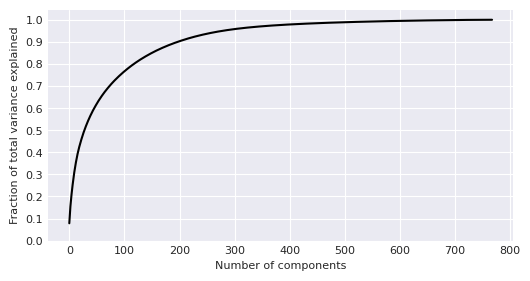

In [17]:
fig,ax=plt.subplots(figsize=(6,3))
ax.plot(np.cumsum(s**2) / np.sum(s**2), c='k')
ax.set_yticks(np.linspace(0,1,11))
ax.set_ylabel('Fraction of total variance explained')
ax.set_xlabel('Number of components');

In [21]:
( np.searchsorted(np.cumsum(s**2) / np.sum(s**2), [0.5, 0.9, 0.95]),
 (np.cumsum(s**2) / np.sum(s**2))[99],
)

(array([ 28, 197, 279]), 0.7645003)

So first 28 components account for 50% of total variance while 197 for 90%. I'll pick 100 for the sake of faster training (arbitrarily, but at least they cover ~77%).

### Training
[[To the top]](#contents)

### Data Preparation

In [7]:
df = pd.read_parquet('/kaggle/input/intermed-results-1/df_no_emb_Feb21.parquet')

cat_cols = ['asked_day', 'asked_hour', 'asked_month' ] +\
[col for col in df.columns if ('tag_' in col)] + ['contains_latex', 'contains_code',
                                                  'contains_img', 'contains_link',
                                                 'is_2020'] 

In [8]:
#emb = np.load('/kaggle/input/intermed-results-1/emb_Feb27_not_cleaned.npy')
emb = np.load('/kaggle/input/intermed-results-1/emb_Feb27_notags_nolinks.npy')

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=100)
z = pca.fit_transform(emb)

In [11]:
df = pd.concat([df, pd.DataFrame(z, 
                                 index = df.index, 
                                 columns=[f'emb_{i:>03}' for i in range(z.shape[1])])], axis=1)

In [12]:
timing = np.load('timing.npy')
df.is_answered = (timing<14).astype(np.int16)

In [13]:
X, y = df.drop(columns=['is_answered']), df.is_answered.values

In [14]:
y.mean()

0.5771630920634576

In [16]:
from sklearn.metrics import ( 
    log_loss, 
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
)
import lightgbm as lgb
from itertools import product

from utils.crossval import (
    ParamGridIter,
    StratifiedNestedKFold
)
from utils.utils import ( 
    summary,
    hist_metrics, 
)

In [11]:
metrics = {
    'acc': accuracy_score,
    'prec': precision_score,
    'rec': recall_score,    
}
metrics_proba = {
    'auc': roc_auc_score,
    'logloss': log_loss,
}

def evaluate(y_true: np.ndarray,
             y_hat: np.ndarray,
             metrics: dict) -> dict[str, float]:
    return {name: metric(y_true, y_hat) for name, metric in metrics.items()}

In [13]:
#import wandb
#wandb.login()

### Cross Validation Setup
[[To the top]](#contents)

I use custom hyperparam iterator (generator, technically) as `sklearn.GridSearch` doesn't allow to specify reasonable subsets of hyperparams to search through (you can only specify the whole Cartesian product, which is stupid). 

I use nested stratified CV: 6 outer folds, 5 inner folds (of them I actually use 5 and 4, to speed up the process a bit). Each split consists of train, eval and test part. Eval is for early stopping. 

In [16]:
param_grid = {
    'data_sample_strategy/bagging_freq/pos_bagging_fraction/neg_bagging_fraction/bagging_fraction': [
    ['bagging',1, 1, 1., 1.],
    ['bagging',2, 0.9, 1, 1],
    ['bagging',2, 0.7, 1, 1]
  ],
  'objective':         ['binary'],
  'boosting':          ['gbdt',],
  'max_bin':           [300],
  'learning_rate':     [0.02],
  'min_gain_to_split': [0.0, ],
  'n_estimators':      [5000],
  'verbose':           [-1],
  'n_jobs':            [4],
  'max_cat_threshold': [32],
  
  'feature_fraction/feature_fraction_bynode':     [[0.1, 1],],
  'n_early_stopping/min_delta/first_metric_only': [[300, 1e-5, True]],
  'max_depth/num_leaves': [
     [5,25],
  ]
}

pg = ParamGridIter(param_grid)

In [18]:
cv = StratifiedNestedKFold(1, 6, 5, 4, 3)

### Training Loop
[[To the top]](#contents)

In [19]:
cv_res_list, models = [], []
seeds = np.random.choice(np.arange(int(10e6)),size=cv.n_repeats)

for ((i_repeat, i_outer, i_inner, perm, ix_test, ix_train, ix_eval),
    (i_param, param_dict)) in product(cv.split(X,y),
                                      enumerate(pg)):
            
    print(f'i_param: {i_param:<2}; i_outer: {i_outer:<2}; i_inner: {i_inner:<2}')
        
    X_train, y_train = X.iloc[ix_train], y[ix_train]
    X_test,  y_test  = X.iloc[ix_test],  y[ix_test]
    X_eval,  y_eval  = X.iloc[ix_eval],  y[ix_eval]
    
    param_seed = {
        'feature_fraction_seed': seeds[i_repeat],
        'bagging_seed': seeds[i_repeat],
    }
    eval_logs = {}
    #run = wandb.init(
    #    project='se_lightgbm',
    #    name=f'fold_{i_param:02}_{i_repeat}_{i_outer}_{i_inner}',
    #    config=param_dict,
    #)
    
    param_fit = {
        'X': X_train,
        'y': y_train,
        'eval_set': [(X_eval, y_eval)],
        'eval_names': ['eval'],
        'callbacks': [
            lgb.early_stopping(param_dict['n_early_stopping'],
                                         param_dict.get('first_metric_only',True), 
                                         min_delta = param_dict['min_delta'],
                                         verbose = False),
                     ],
        'categorical_feature': cat_cols,
    }
    model = lgb.LGBMClassifier(**param_dict, **param_seed).fit(**param_fit)
    
    test_loss = evaluate(y_test, model.predict(X_test), metrics)
    test_loss_proba = evaluate(y_test, model.booster_.predict(X_test), metrics_proba)
    test_loss.update(test_loss_proba)
    
    cv_res_list.append([i_repeat, i_outer, i_inner, i_param, param_dict, eval_logs,
                        [ix_train, ix_test, ix_eval]] + [v for v in test_loss.values()])
    models.append(model)

i_param: 0 ; i_outer: 0 ; i_inner: 0 

i_param: 1 ; i_outer: 0 ; i_inner: 0 

i_param: 2 ; i_outer: 0 ; i_inner: 0 

i_param: 0 ; i_outer: 0 ; i_inner: 1 

i_param: 1 ; i_outer: 0 ; i_inner: 1 

i_param: 2 ; i_outer: 0 ; i_inner: 1 

i_param: 0 ; i_outer: 0 ; i_inner: 2 

i_param: 1 ; i_outer: 0 ; i_inner: 2 

i_param: 2 ; i_outer: 0 ; i_inner: 2 

i_param: 0 ; i_outer: 1 ; i_inner: 0 

i_param: 1 ; i_outer: 1 ; i_inner: 0 

i_param: 2 ; i_outer: 1 ; i_inner: 0 

i_param: 0 ; i_outer: 1 ; i_inner: 1 

i_param: 1 ; i_outer: 1 ; i_inner: 1 

i_param: 2 ; i_outer: 1 ; i_inner: 1 

i_param: 0 ; i_outer: 1 ; i_inner: 2 

i_param: 1 ; i_outer: 1 ; i_inner: 2 

i_param: 2 ; i_outer: 1 ; i_inner: 2 

i_param: 0 ; i_outer: 2 ; i_inner: 0 

i_param: 1 ; i_outer: 2 ; i_inner: 0 

i_param: 2 ; i_outer: 2 ; i_inner: 0 

i_param: 0 ; i_outer: 2 ; i_inner: 1 

i_param: 1 ; i_outer: 2 ; i_inner: 1 

i_param: 2 ; i_outer: 2 ; i_inner: 1 

i_param: 0 ; i_outer: 2 ; i_inner: 2 

i_param: 1 ; i_outer: 2 ;

In [20]:
cv_res_df = pd.DataFrame(
        columns=['i_repeat', 'fold_outer', 'fold_inner', 'i_param', 'params', 'evals', 'inds'] + \
    ['test_'+name for name in metrics.keys()] + \
    ['test_'+name for name in metrics_proba.keys()],
    data=cv_res_list)

In [ ]:
cv_res_df.to_csv('dummy.csv')

In [ ]:
sm = summary(cv_res_df, ['median'])
fixed_params = [col for col in sm.columns if sm[col].unique().shape[0]==1]

In [ ]:
( sm
 .sort_values(['test_logloss/median'], ascending=True)
 .drop(columns=fixed_params)
 .iloc[:10]
)

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.614055          0.621860         0.843202   
1        1         0.613963          0.621544         0.846848   
4        4         0.614908          0.622609         0.837767   
5        5         0.613784          0.621886         0.842447   
3        3         0.613924          0.622274         0.838269   
2        2         0.613409          0.620491         0.846832   
7        7         0.609216          0.617530         0.843745   
6        6         0.609672          0.617920         0.846667   
8        8         0.608287          0.617727         0.843474   

   test_auc/median  test_logloss/median  bagging_freq  bagging_fraction  \
0         0.628683             0.654974             1               1.0   
1         0.627838             0.655170             1               1.0   
4         0.627661             0.655202             4               0.6   
5         0.626922             0.655258             4               0.6   
3         0.627610             0.655263             4               0.6   
2         0.626447             0.655696             1               1.0   
7         0.618661             0.658386             4               0.2   
6         0.618372             0.658667             4               0.2   
8         0.618640             0.658948             4               0.2   

   feature_fraction  
0               0.1  
1               0.2  
4               0.2  
5               0.3  
3               0.1  
2               0.3  
7               0.2  
6               0.1  
8               0.3

### Results (So Far)
[[To the top]](#contents)

Note, those are lower bound estimates since we use *nested* CV.

Lots of intermediate results of hyperparameter search are omitted here for brevity. Best **roc auc** w/t embedding is 0.629. With embedding **roc auc** is 0.658 (100 dims PCA from 768-dim vector).



### Overview

In [ ]:
import shap
shap.initjs()

In [ ]:
def display_cv_res_df(path, topk=10, sort_by='test_logloss/median', ascending=True):
    cv_res_df = pd.read_csv(path)
    sm = summary(cv_res_df, ['median'])
    fixed_params = [col for col in sm.columns if sm[col].unique().shape[0]==1]
    return ( sm
            .sort_values(sort_by, ascending=ascending)
            .drop(columns=fixed_params)
            .iloc[:topk]
           )

### W/t Embeddings

In [33]:
display_cv_res_df('cv_res_df_Apr14_06:30.csv')

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.614055          0.621860         0.843202   
1        1         0.613963          0.621544         0.846848   
4        4         0.614908          0.622609         0.837767   
5        5         0.613784          0.621886         0.842447   
3        3         0.613924          0.622274         0.838269   
2        2         0.613409          0.620491         0.846832   
7        7         0.609216          0.617530         0.843745   
6        6         0.609672          0.617920         0.846667   
8        8         0.608287          0.617727         0.843474   

   test_auc/median  test_logloss/median  bagging_freq  bagging_fraction  \
0         0.628683             0.654974             1               1.0   
1         0.627838             0.655170             1               1.0   
4         0.627661             0.655202             4               0.6   
5         0.626922             0.655258             4               0.6   
3         0.627610             0.655263             4               0.6   
2         0.626447             0.655696             1               1.0   
7         0.618661             0.658386             4               0.2   
6         0.618372             0.658667             4               0.2   
8         0.618640             0.658948             4               0.2   

   feature_fraction  
0               0.1  
1               0.2  
4               0.2  
5               0.3  
3               0.1  
2               0.3  
7               0.2  
6               0.1  
8               0.3

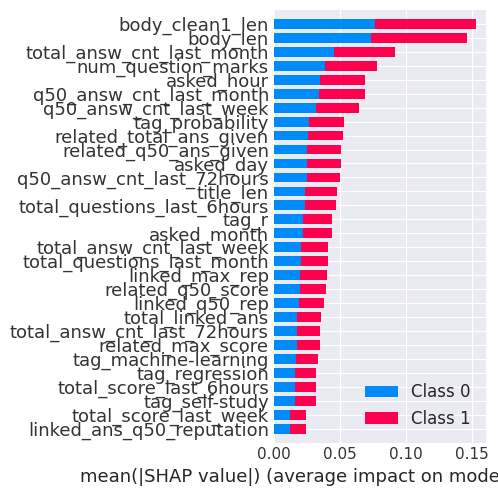

In [49]:
shap.summary_plot(shap_values, X, plot_size=(5,5), max_display=30,)

### With Embeddings (Unfiltered)

In [38]:
display_cv_res_df('cv_res_df_Apr9_13:30.csv')

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.628230          0.640338         0.806626   
1        1         0.626900          0.640726         0.805581   
8        8         0.627747          0.641451         0.805183   
7        7         0.628171          0.641861         0.804496   
6        6         0.627503          0.641174         0.802809   
2        2         0.627536          0.640538         0.806705   
5        5         0.622664          0.636900         0.805315   
4        4         0.623358          0.637712         0.805084   
3        3         0.622947          0.636630         0.808836   

   test_auc/median  test_logloss/median  bagging_freq  bagging_fraction  \
0         0.657787             0.641948             1               1.0   
1         0.657548             0.642325             1               1.0   
8         0.657406             0.642416             4               0.7   
7         0.657198             0.642517             4               0.7   
6         0.657170             0.642537             4               0.7   
2         0.657010             0.642552             1               1.0   
5         0.650541             0.645652             4               0.2   
4         0.650006             0.645816             4               0.2   
3         0.649836             0.646145             4               0.2   

   feature_fraction  
0               0.1  
1               0.2  
8               0.3  
7               0.2  
6               0.1  
2               0.3  
5               0.3  
4               0.2  
3               0.1

### CV Logloss Spread

Just an example from one of the runs

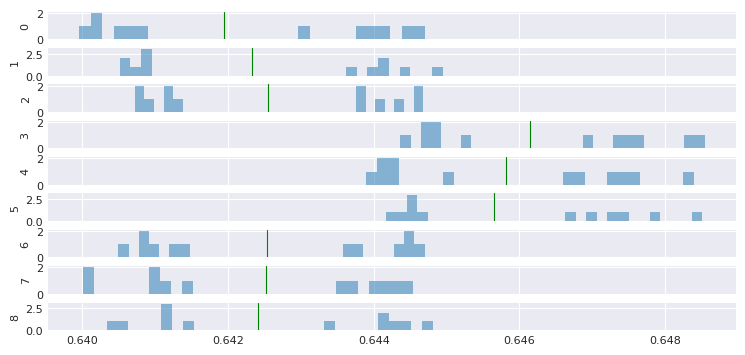

In [44]:
cv_res_df = pd.read_csv('cv_res_df_Apr9_13:30.csv')
hist_metrics((7.5,3.6), cv_res_df, 'test_logloss')

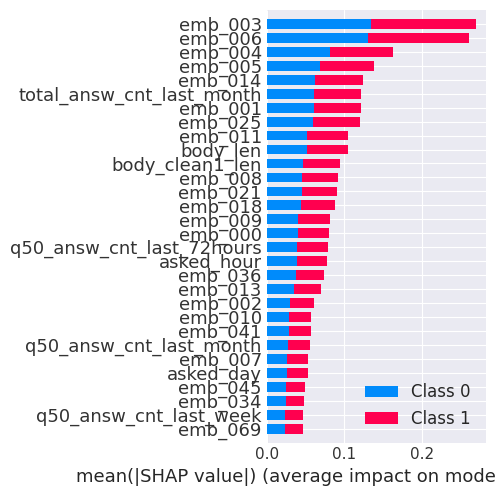

In [46]:
shap.summary_plot(shap_values, X, plot_size=(5,5), max_display=30 )

In [33]:
y.mean(), (1-y.mean())/y.mean()

(0.5771630920634576, 0.7326125210550583)

Class imbalance could be alleviated via undersampling. I believe false positives here are more harmful than false negatives (so we should optimize precision): getting a false negative would make you rethink/reformulate the question, which never hurts; a false positive misleads you into believing that question is ok.

In [48]:
display_cv_res_df('cv_res_df_Apr15_12:50.csv')

i_param  test_acc/median  test_prec/median  test_rec/median  \
1        1         0.629990          0.643676         0.807374   
0        0         0.629517          0.643347         0.806595   
3        3         0.617695          0.678707         0.641093   
2        2         0.617460          0.679375         0.641308   

   test_auc/median  test_logloss/median  bagging_freq  pos_bagging_fraction  \
1         0.659585             0.641214             1                  1.00   
0         0.658952             0.641484             1                  1.00   
3         0.658988             0.649988             2                  0.73   
2         0.658854             0.650210             2                  0.73   

   feature_fraction  
1               0.1  
0               0.2  
3               0.1  
2               0.2

### With Embeddings (Filtered)

Filtered means web links and html tags were removed from the question body prior to embedding. Works slightly better, yielding roc auc 0.661. 

Undersampling here doesn't help.

In [24]:
( sm
 .sort_values(['test_logloss/median'], ascending=True)
 .drop(columns=fixed_params + ['test_acc/std', 'test_prec/std', 'test_rec/std', 'test_auc/std', 'test_logloss/std'])
 .iloc[:10]
)

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.628165          0.640782         0.807169   
1        1         0.626959          0.654450         0.755245   
2        2         0.612784          0.682397         0.612406   

   test_auc/median  test_logloss/median data_sample_strategy  bagging_freq  \
0         0.657401             0.642290              bagging             1   
1         0.657410             0.643481              bagging             2   
2         0.656438             0.653989              bagging             2   

   pos_bagging_fraction  neg_bagging_fraction  bagging_fraction  
0                   1.0                   1.0               1.0  
1                   0.9                   1.0               1.0  
2                   0.7                   1.0               1.0

Heavier positive undersampling makes things worse (even worse than slight negative undersampling, 2nd table below)

In [62]:
display_cv_res_df('cv_res_df_Apr15_15:30.csv')

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.630925          0.643104         0.806032   
1        1         0.578046          0.577998         1.000000   
2        2         0.577622          0.577622         1.000000   

   test_auc/median  test_logloss/median  bagging_freq  pos_bagging_fraction  
0         0.660923             0.640572             1                   1.0  
1         0.605323             0.679576             2                   0.6  
2         0.590290             0.680530             2                   0.4

In [63]:
display_cv_res_df('cv_res_df_Apr15_20:30.csv')

i_param  test_acc/median  test_prec/median  test_rec/median  \
0        0         0.630316          0.642857         0.808513   
1        1         0.625857          0.623055         0.889068   
2        2         0.577785          0.577650         1.000000   

   test_auc/median  test_logloss/median  bagging_freq  neg_bagging_fraction  
0         0.660986             0.640480             1                   1.0  
1         0.660947             0.645133             2                   0.8  
2         0.610530             0.679329             2                   0.6

### Feature Importance
[[To the top]](#contents)

In [34]:
import shap
shap.initjs()

In [ ]:
model = lgb.Booster(model_file='lgb_models/Apr11_12:30_upd/001_0_0_0_01.txt')

In [35]:
# using random 70% subset to speed up shap calculation
inds = np.random.choice(np.arange(X.shape[0]), int(0.7*X.shape[0]))

In [38]:
explainer = shap.TreeExplainer(models[1])
shap_values = explainer.shap_values(X.iloc[inds])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [68]:
top15 = np.array(list(X.columns))[np.argsort(-np.abs(shap_values[1]).mean(axis=0))][:15]
top15_50 = [x for x in np.array(list(X.columns))[np.argsort(-np.abs(shap_values[1]).mean(axis=0))][:50] \
         if 'emb_' not in x][:15]

#### All Features Top-15

Most of the top features are embedding dimensions. And there is a remarkably clear monotonicity (if not linearity) between them and shap values, although they are not interpretable right now

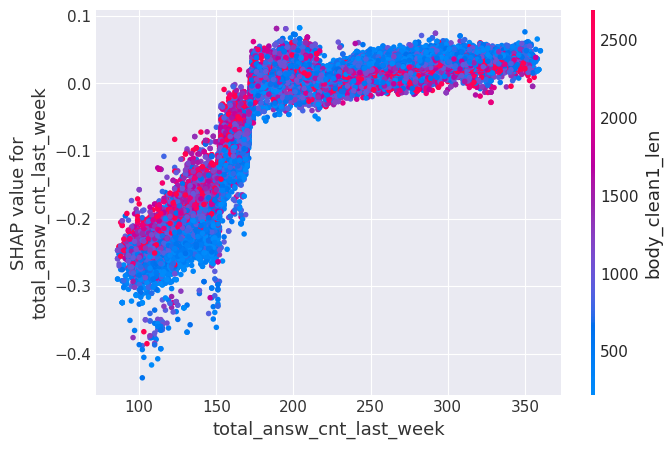

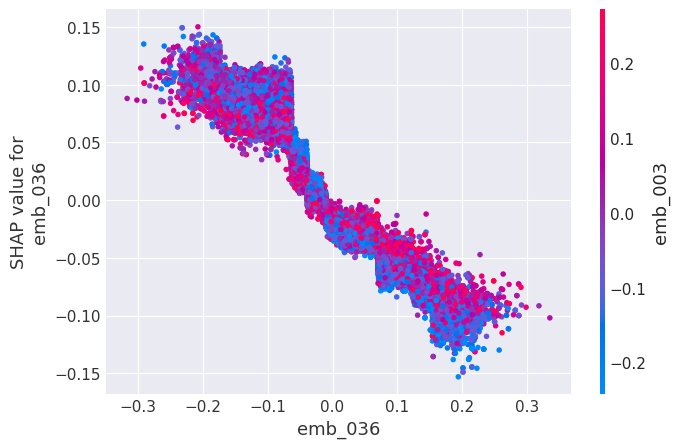

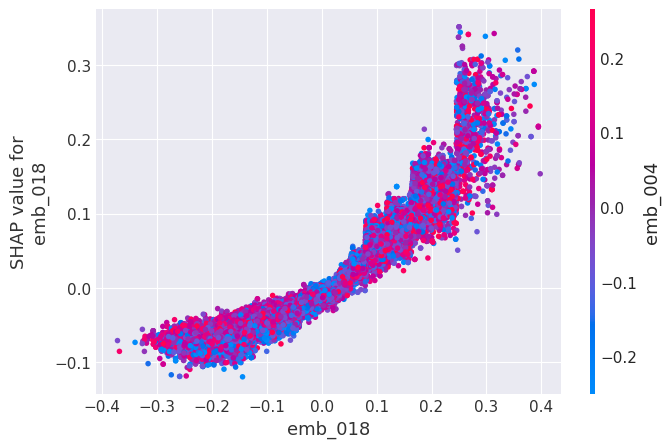

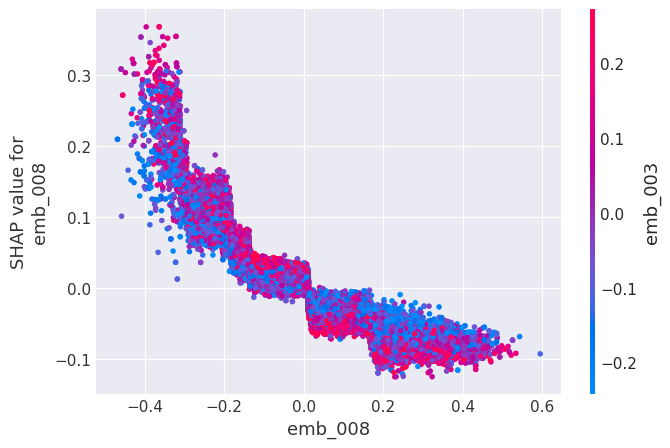

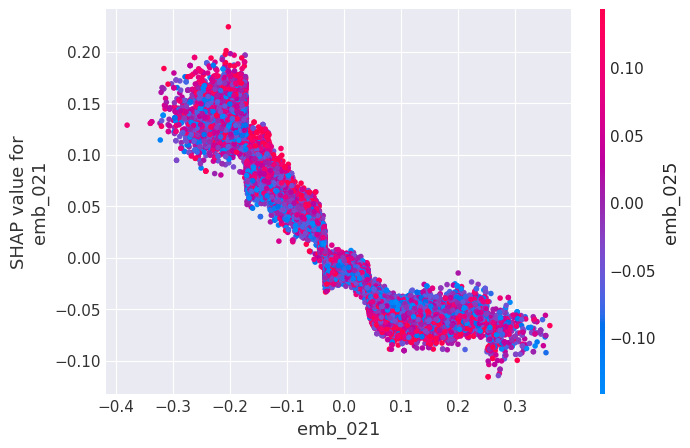

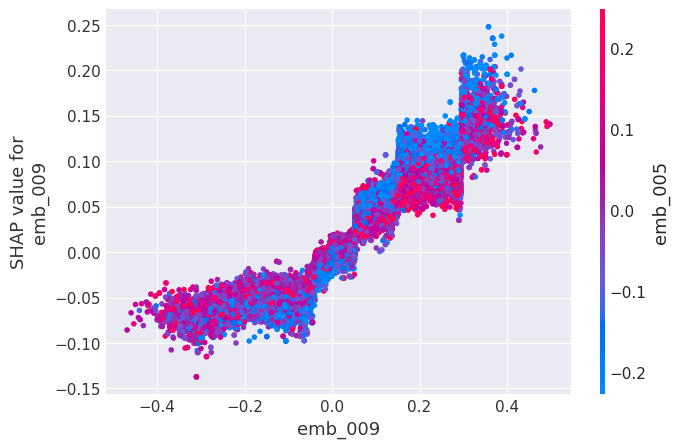

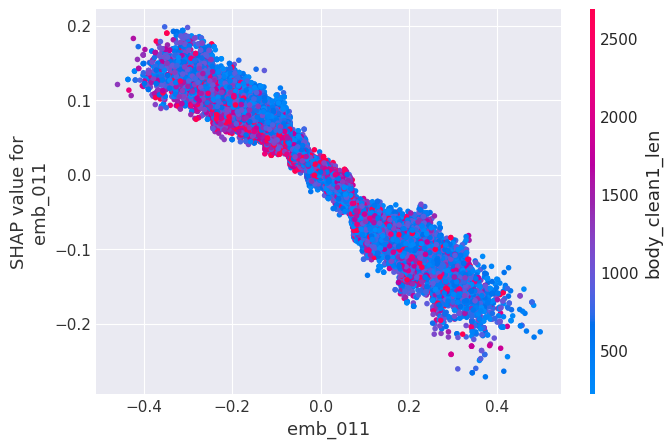

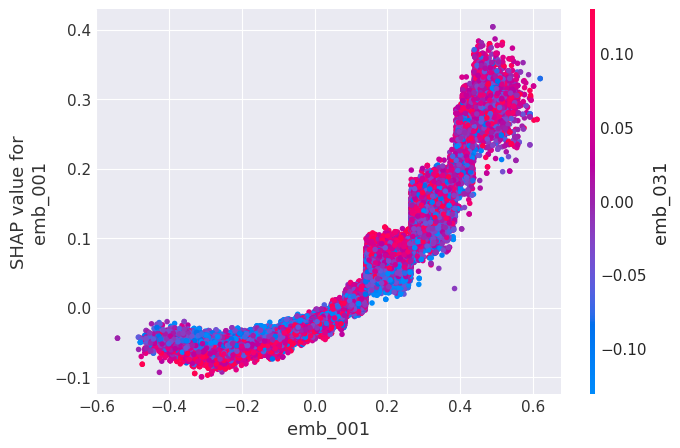

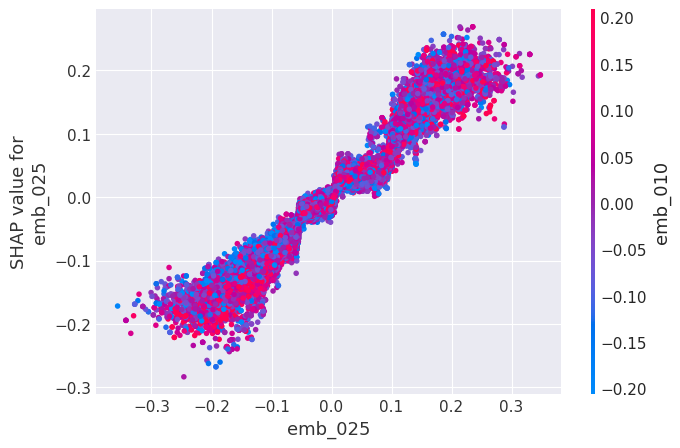

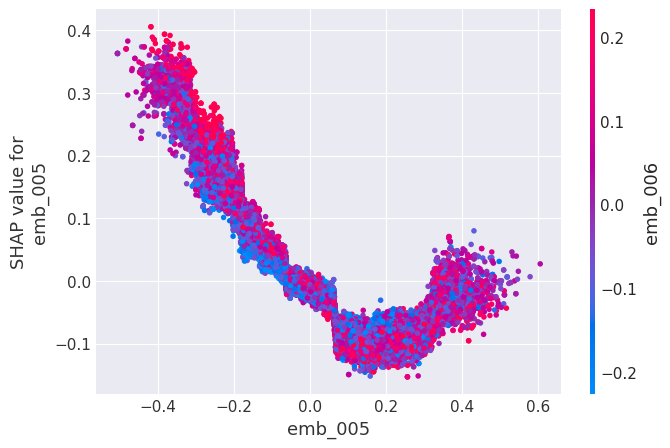

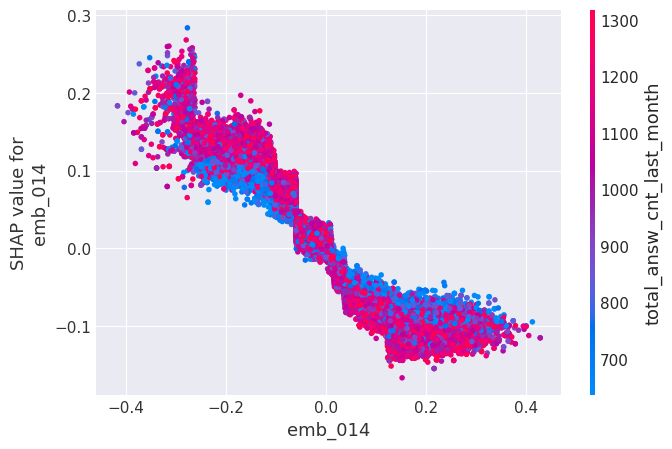

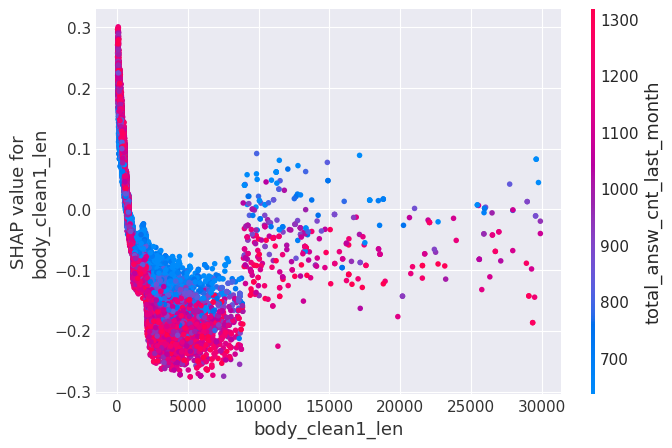

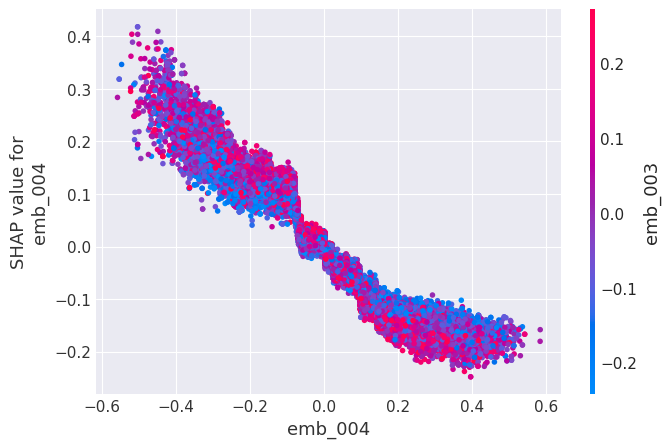

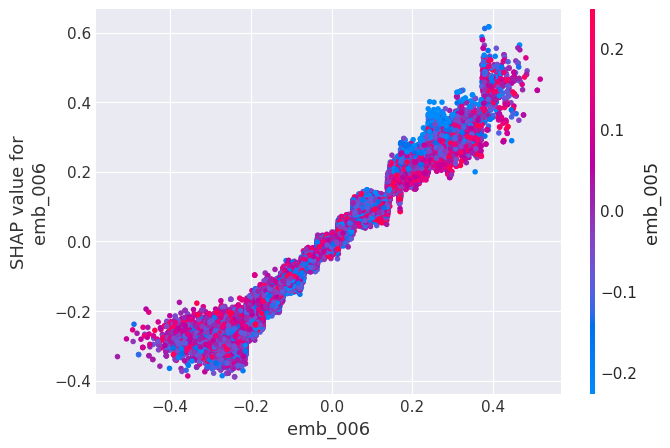

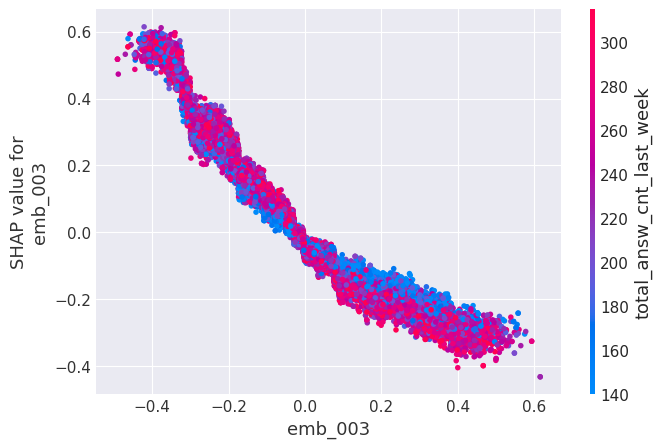

In [50]:
for feat in top15:
    shap.dependence_plot(feat, shap_values[1], X.iloc[inds], display_features=X)

#### Non-embedding Features

Feature importance below suggests that:
1. Shorter questions are more likely to be addressed (`body_clean1_len`, `body_len`), but for lengths greater than 8000-9000 symbols this feature ceases to be important
2. The more answers there is in the recent past, the more likely your question would be addressed (`total_answ_cnt_last_week`, `q_50_answ_cnt_last_week`, `total_answ_cnt_last_month`, `q_50_answ_cnt_last_72hours`), ie recent answering activity is predictive of the future answering activity
3. On the other hand, the more questions there is in the recent past, the less likely your own would be tackled (`total_question_cnt_*`), ie greater demand is harder to satisfy (inter alia)
4. It helps to ask your question in the first half of the day (`asked_hour`)
5. The more answers there is among related questions, the more likely your own would be addressed (`related_q50_ans_given`). This is not inututive. It's possible, that the more related answers there are, the more likely your question would be closed as 'already answered', so net effect is unclear
6. And finally, your question is much more likely to be answered, if you ask it in July!

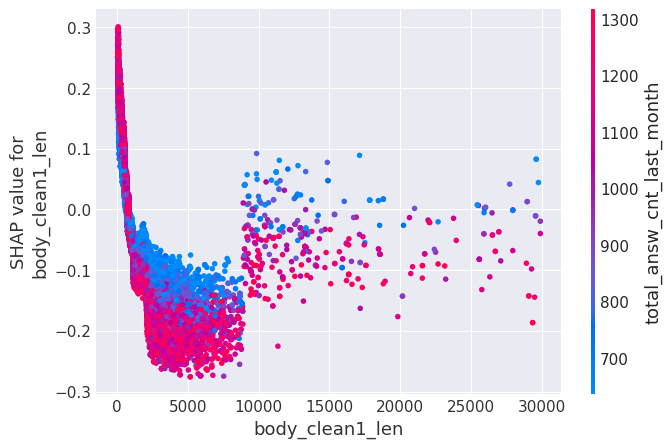

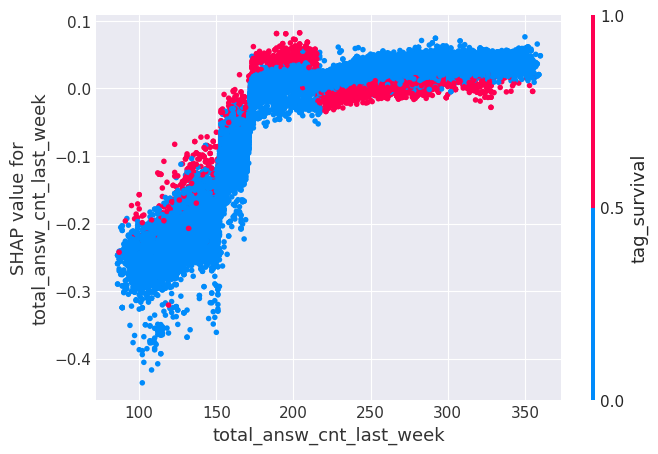

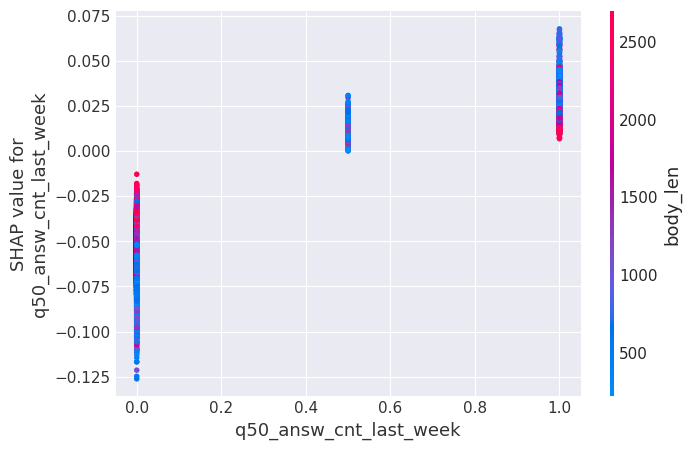

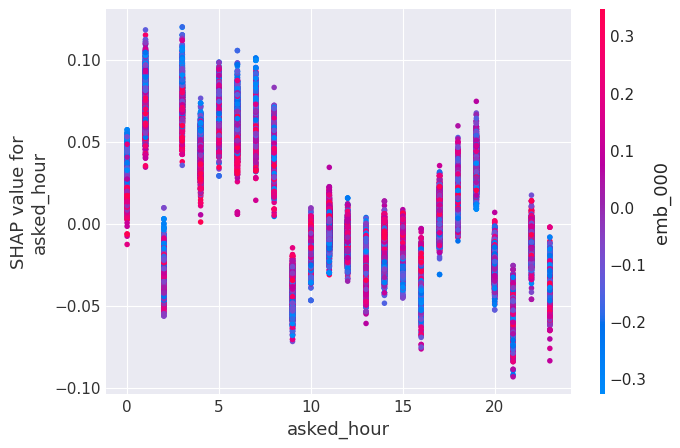

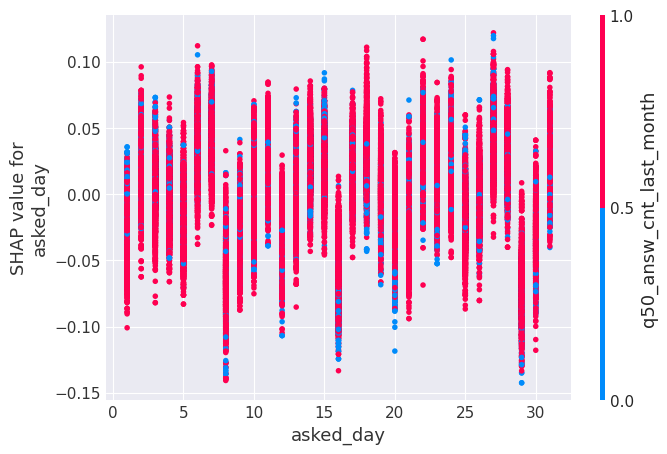

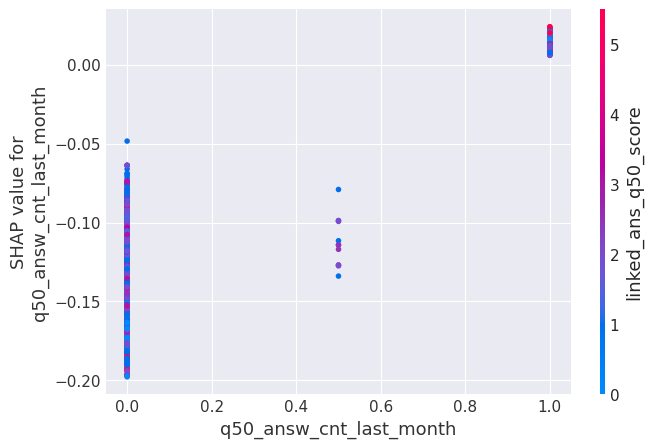

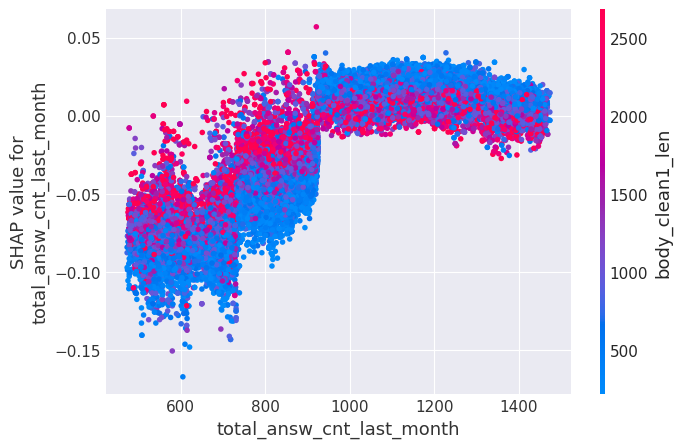

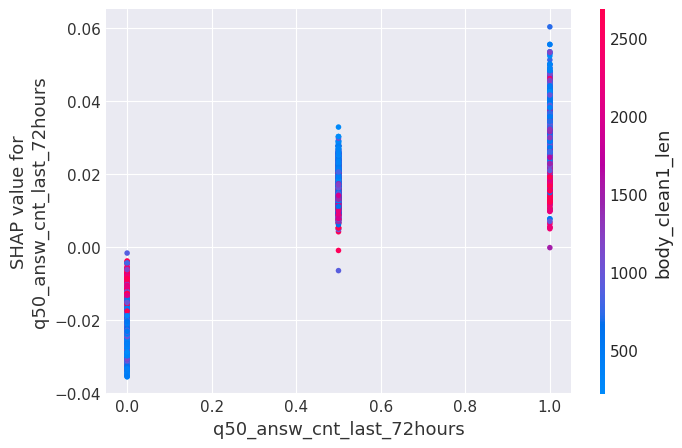

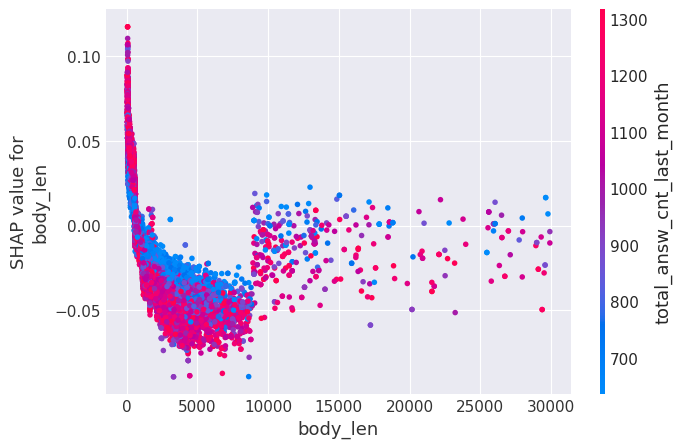

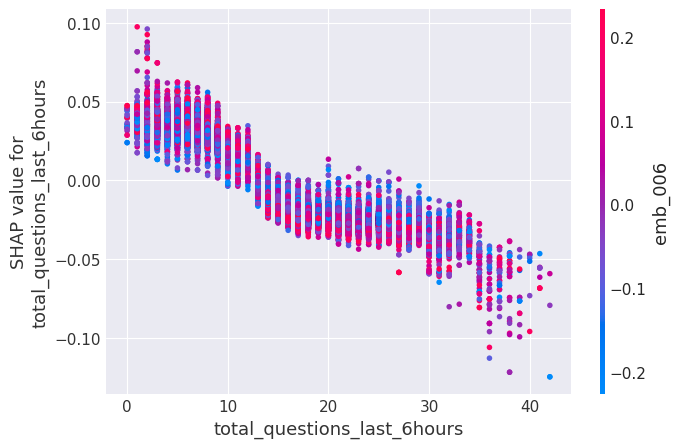

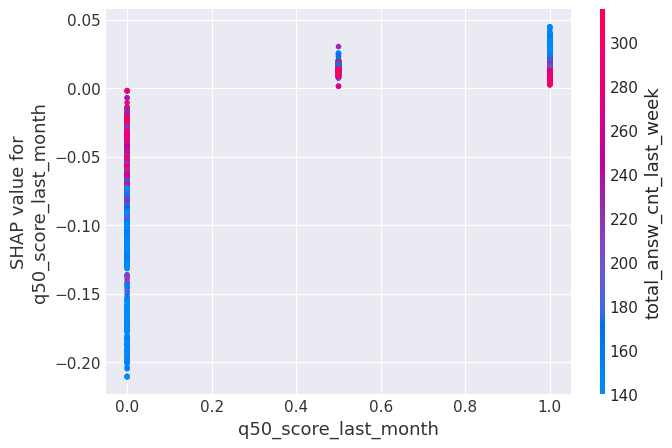

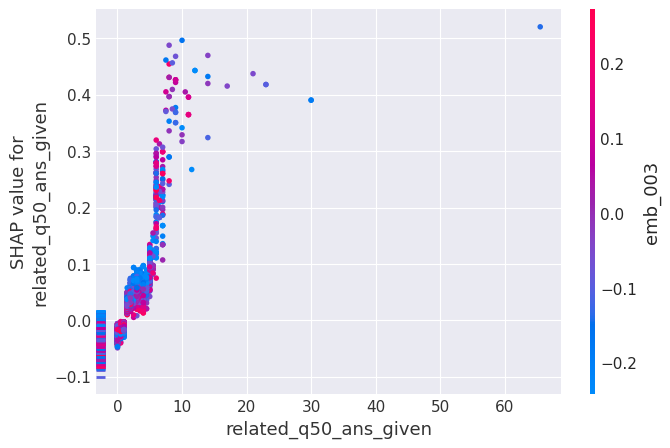

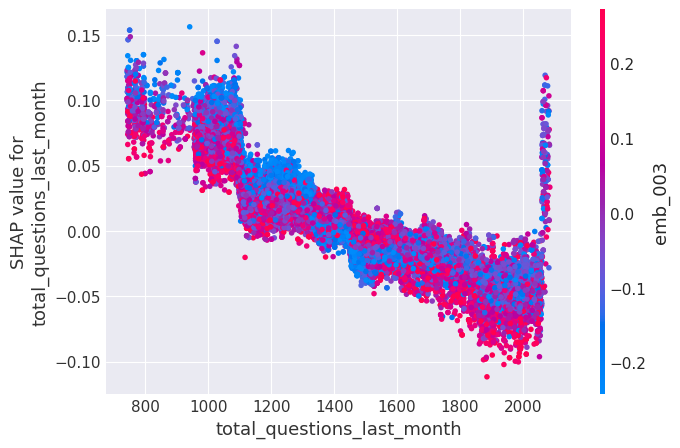

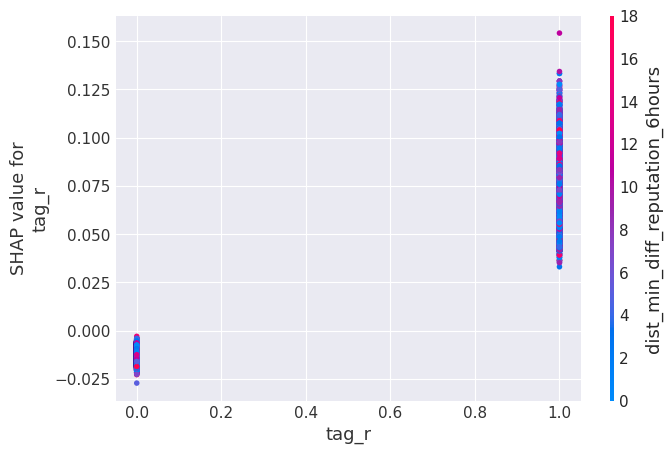

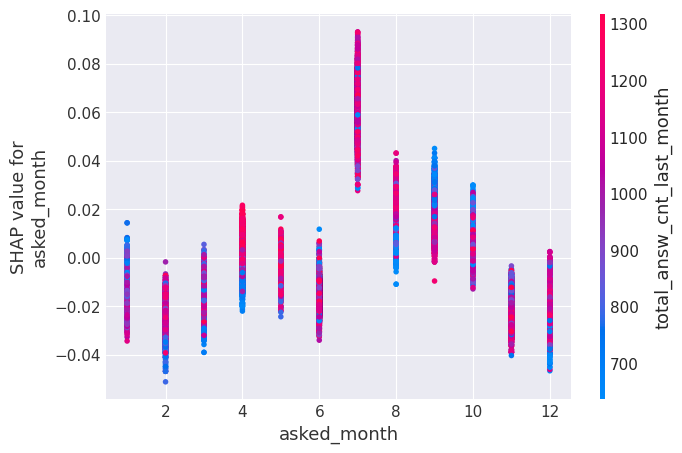

In [70]:
for feat in top15_50:
    shap.dependence_plot(feat, shap_values[1], X.iloc[inds], display_features=X)

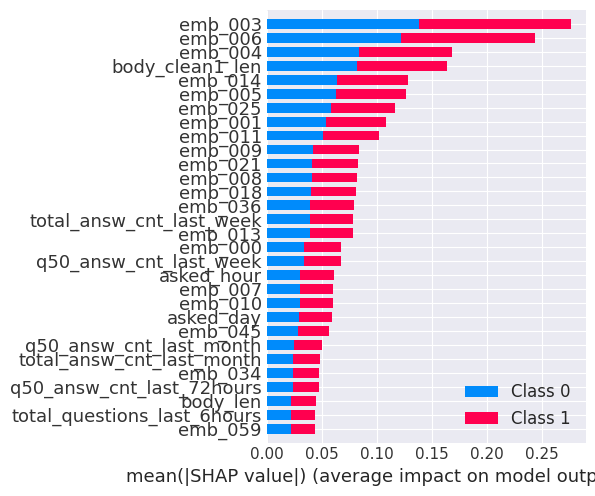

In [41]:
plt.rcParams.update({'font.size': 8})
shap.summary_plot(shap_values, X, plot_size=(6,5), max_display=30,)

In [30]:
np.save('shap_arr1.npy', shap_values[1])

### Future Work
[[To the top]](#contents)

Boring and technical: 

1. Try out different sorts of embeddings 
2. Try out different aggregate features
3. Train a separate transformer model solely on question bodies
4. Incorporate new features
5. Interpret embedding features

Re (5): importance plots show very clear, almost linear, shap values for certain embedding dimensions. Moreover they are among most important features overall, but they are uninterpretable right now. Shap could be applied to transformer models directly to highlight important tokens, that's one possible approach. Are there others?

More interesting:

1. Train boostings for different horizons (marking questions as positive if they were answered in 1 day, 7 days, 1 month, etc) and combining results
2. Make prediction at a different point in time 

Regarding the latter, it seems plausible that probability of being answered changes significantly with time. As we've seen most questions are addressed in the first day. But during the first day many things could happen, which our model doesn't see: question could be edited (by its author or by community members); it could recieve comments; it could recieve new tags, etc.

Some of those events not only make question more appealing, but also raise its visibility: for example, an edit brings question back on the first page. Without those events a question would be crowded out and forgotten: from importance plots we see that number of recent questions is inversely related to the probability of being answered.

Therefore it makes sense to try make prediction, say, 15 min or 3 h after posting, when those changes get accumulated. 

Do the data support this hypothesis?

### View Count

Question's view count is shown on question preview and seems like an obvious measure of popularity. Unfortunately, dump only includes final view counts, not their history, hence it can't be used as a feature (but its correlates could)

In [ ]:
view_cnt = np.array([q['ViewCount'] for q in questions])
answ_cnt = np.array([q['AnswerCount'] for q in questions])
score_cnt = np.array([q['Score'] for q in questions])

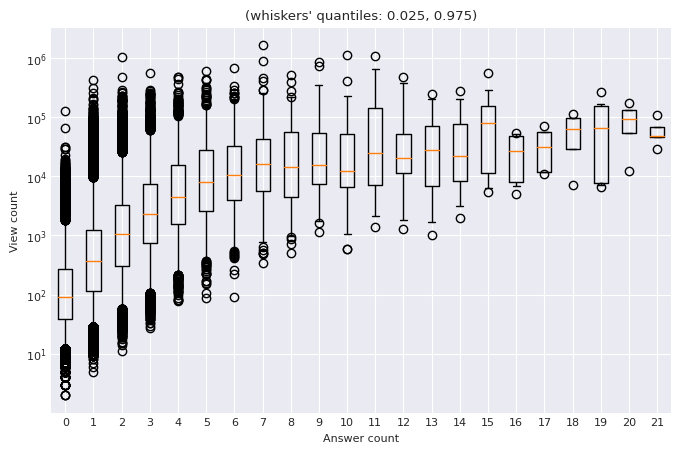

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot([view_cnt[answ_cnt==i] for i in range(22)], 
           whis=[2.5,97.5],
           positions=range(22))
ax.set_ylabel('View count')
ax.set_xlabel('Answer count')
ax.set_title('(whiskers\' quantiles: 0.025, 0.975)')
ax.set_yscale('log')

Log-scale plot shows clear monotonic relation (with saturation) between view count and answer count

In [ ]:
edit_cnt = np.array([sum(x['PostHistoryTypeId'] in [4,5,6,7,8,9,24] for x in phist_dict[q['Id']]) 
                     for q in questions])

In [ ]:
edit_cnt_unique = np.unique(edit_cnt)
edit_cnt_unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 39, 42, 69])

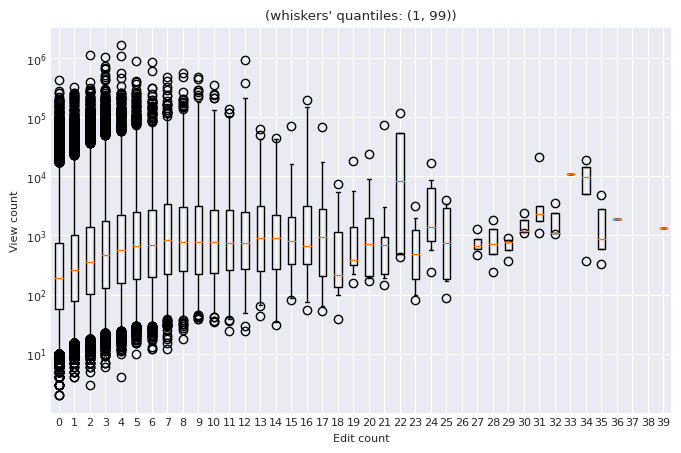

In [ ]:
whisk = (1,99)
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot([view_cnt[edit_cnt==i] for i in np.arange(40)], 
           whis=whisk,
           positions=np.arange(40))
ax.set_ylabel('View count')
ax.set_xlabel('Edit count')
ax.set_title(f'(whiskers\' quantiles: {whisk})')
#ax.set_ylim((-1, 40))
ax.set_yscale('log')